In [1]:
import os.path
from scipy import *
import scipy as sp
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import math as math
from math import factorial as fact

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 128
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 1
deriv = 'CD'
order = 1

In [3]:
omega = BT.Grid(nh)
# finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
# omega.AddPatch(refRatio, finehalf)
nh_min = omega.nh_min
waves = WT.MakeWaves(omega)
print(waves)

[[ 1.          0.02453876  0.99959845  0.04904797  0.99839439  0.07349811  0.99638956  0.09785976  0.99358685  0.12210366  0.98999032  0.14620071  0.98560515  0.17012208  0.98043768  0.19383918  0.97449536  0.21732378  0.96778676  0.24054802  0.96032155  0.26348445  0.95211046  0.28610607  0.94316532  0.3083864   0.93349897  0.33029951  0.92312528  0.35182002  0.91205911  0.37292323  0.90031632  0.39358506  0.88791367  0.41378216  0.87486887  0.4334919   0.8612005   0.45269244  0.84692799  0.47136274  0.83207161  0.4894826   0.81665238  0.50703269  0.80069212  0.52399458  0.7842133   0.54035076  0.76723913  0.55608469  0.7497934   0.57118078  0.73190053  0.58562448  0.71358549  0.59940221  0.69487374  0.61250146  0.67579123  0.62491078  0.65636432  0.63661977  0.63661977  0.64761913  0.61658467  0.65790063  0.59628638  0.66745718  0.57575253  0.67628278  0.55501094  0.68437255  0.53408958  0.69172273  0.51301654  0.69833068  0.49181995  0.70419489  0.47052798  0.70931496  0.44916875  0

In [4]:
def VectorNorm(v, normType = 'L2'):
    n = len(v)
    if (normType == 'max'):
            norm = max(v)
    else:
        if (normType == 'L1'):
            norm = sum(v) / n
        else:
            norm = np.sqrt(sum(v ** 2))
            print(v)
            print(v ** 2)
            print(sum(v ** 2))
            print(norm)
    return norm

In [5]:
def ModeProp(omega, nt, c, CFL, deriv, RK, order):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    
    if (RK == 1):
        TimeIntegratorFunc = ST.ForwardEuler
    else:
        if (RK == 2):
            TimeIntegratorFunc = ST.MidpointMeth
        else:
            TimeIntegratorFunc = ST.RK4

    if (deriv == 'U'):
        # DiffMatFunc = OT.Upwind1D
        DiffFunc = TT.Upwind#ST.Upwind
    else:
        # DiffMatFunc = OT.CenterDiff1D
        DiffFunc = TT.CenterDiff#ST.CenterDiff

    t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
    derivMat = OT.SpaceDeriv(omega, order, deriv)
    spatOp = -c * derivMat
    strings = omega.strings
    timePropOp = LA2.expm(t * spatOp)
    waves = WT.MakeWaves(omega)
    omegaF = BT.Grid(nh_max)
    wavesF = WT.MakeWaves(omegaF)
    restrictOp = GTT.CoarsenOp(omega)
    nullspace = OT.FindNullspace(omega, waves)
    
    FCoefsF = np.eye(nh_max)# [:, :nh_min]
    FCoefs = np.zeros((degFreed, nh_max), float)
    propFCoefs = np.zeros((degFreed, nh_max), float)
    solvFCoefs = np.zeros((degFreed, nh_max), float)
    exTimeCoefs = np.zeros((degFreed, nh_max), float)
    
#     print('derivMat =\n', derivMat, '\n')
#     print('spatOp =\n', spatOp, '\n')
#     print('timePropOp =\n', timePropOp, '\n')

    for k in range(nh_max):
        waveformF = wavesF @ FCoefsF[:, k] # nullspace[:, k]
        propFCoefs[:, k] = FFTT.PropRestrictWaves(omega, waveformF, c, t)
        waveform = restrictOp @ waveformF
        FCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

        solvFCoefs[:, k] = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
        exTimeForm = timePropOp @ waveform
        exTimeCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)
    
    propFCoefs = nullspace @ propFCoefs
    solvFCoefs = nullspace @ solvFCoefs
    exTimeCoefs = nullspace @ exTimeCoefs
    return propFCoefs, solvFCoefs, exTimeCoefs

In [6]:
def ModeError(omega, nt, c, CFL, deriv, RK, order, normType = 'L2', errorType = 'absolute'):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    n = int((nh_max / 2) + 2)
    propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, nt, c, CFL, deriv, RK, order)
    solvError = np.zeros(nh_max, float)
    exTimeError = np.zeros(nh_max, float)
    solvNorm = np.zeros(nh_max, float)
    for k in range(nh_max):
        ks, solvErrorVec = TT.AmpError(omega, propFCoefs[:, k], solvFCoefs[:, k])
        ks, exTimeErrorVec = TT.AmpError(omega, propFCoefs[:, k], exTimeCoefs[:, k])
        
        title = 'Amplitude Norm Error for Mode ' + str(k)
        fig, ax = plt.subplots(figsize = [20, 6])
        plt.plot(ks, solvErrorVec, label = 'Solver Error', color = PT.ColorDefault(0))
        plt.scatter(ks, solvErrorVec, color = PT.ColorDefault(0))
        plt.plot(ks, exTimeErrorVec, label = 'Exact Time Error', color = PT.ColorDefault(1))
        plt.scatter(ks, exTimeErrorVec, color = PT.ColorDefault(1))
        plt.title(title)
        plt.xlabel('Wavenumber')
        plt.ylabel('Error')
        plt.legend()
        # plt.ylim(-1, 1.1)
        plt.show()
        print('')
        print(k)
        print('solvError:')
        solvError[k] = VectorNorm(solvErrorVec, normType)
        print('exTimeError:')
        exTimeError[k] = VectorNorm(exTimeErrorVec, normType)
        print('solvNorm:')
        solvNorm[k] = VectorNorm(solvFCoefs[:, k], normType)
        print('')
        
#         if (normType == 'max'):
#             solvError[k] = max(solvErrorVec)
#             exTimeError[k] = max(exTimeErrorVec)
#             solvNorm[k] = max(solvFCoefs[:, k])
#         else:
#             if (normType == 'L1'):
#                 solvError[k] = sum(solvErrorVec) / nh_max
#                 exTimeError[k] = sum(exTimeErrorVec) / nh_max
#                 solvNorm[k] = sum(solvFCoefs[:, k]) / nh_max
#             else:
#                 solvError[k] = sum(solvErrorVec) / nh_max
#                 exTimeError[k] = sum(exTimeErrorVec) / nh_max
#                 solvNorm[k] = np.sqrt(sum(solvFCoefs[:, k] ** 2))
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    return ks, solvError, exTimeError , solvNorm

Actual:
[ 1.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -1.e-15  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -1.e-15 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00

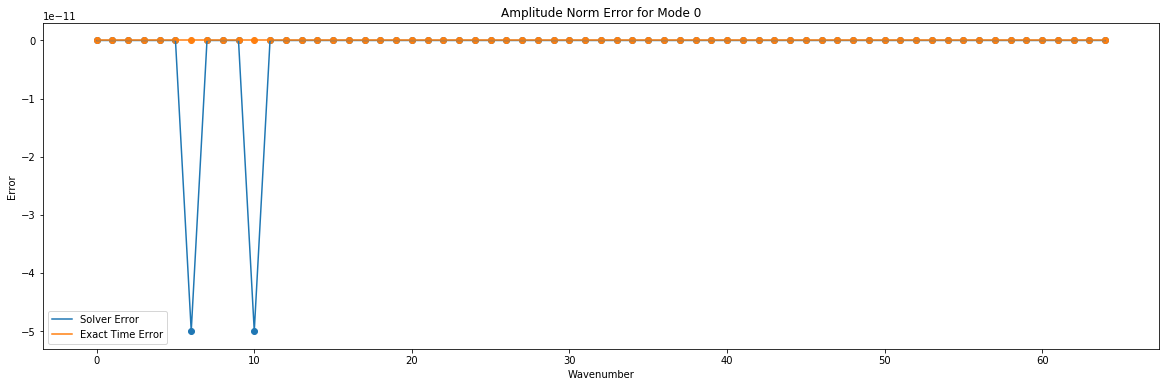


0
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

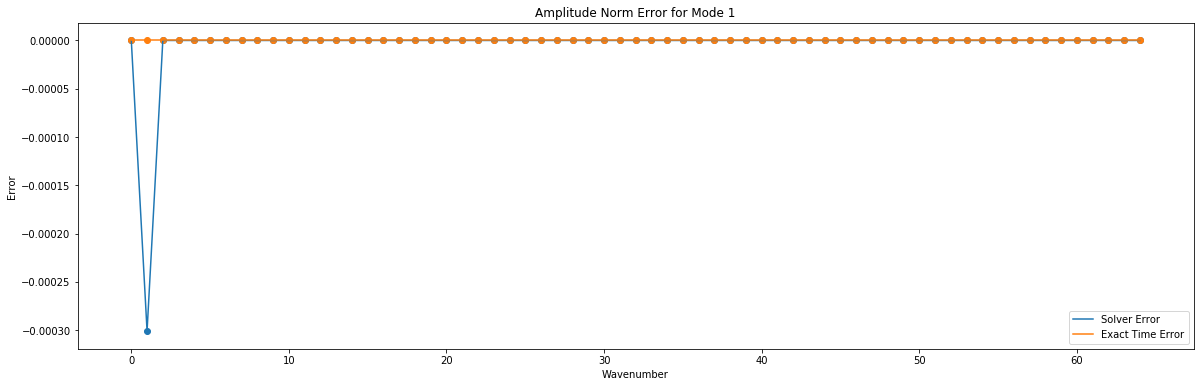


1
solvError:
[ 0.00000000e+00 -3.00909310e-04 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

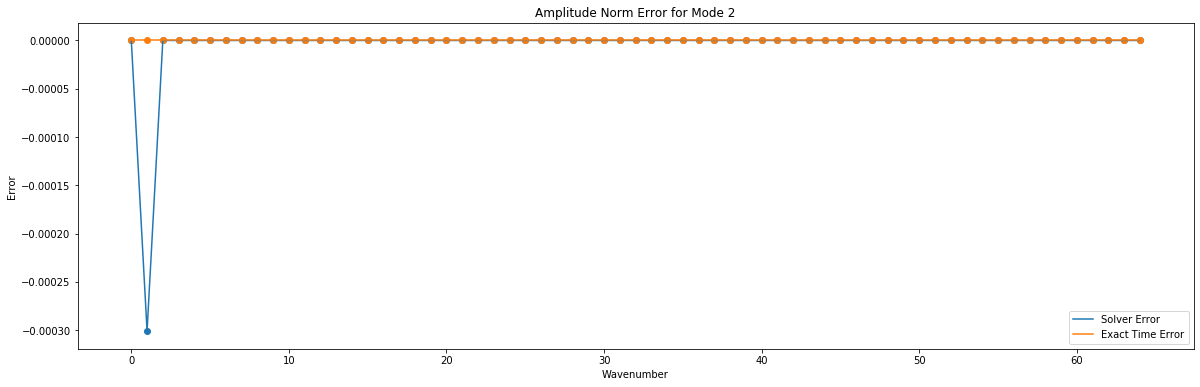


2
solvError:
[ 0.00000000e+00 -3.00909310e-04 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

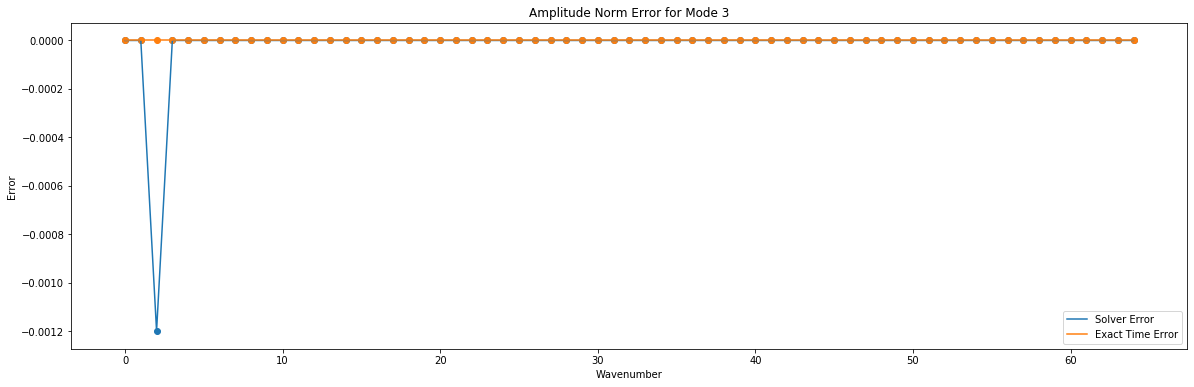


3
solvError:
[ 0.00000000e+00  0.00000000e+00 -1.20019974e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

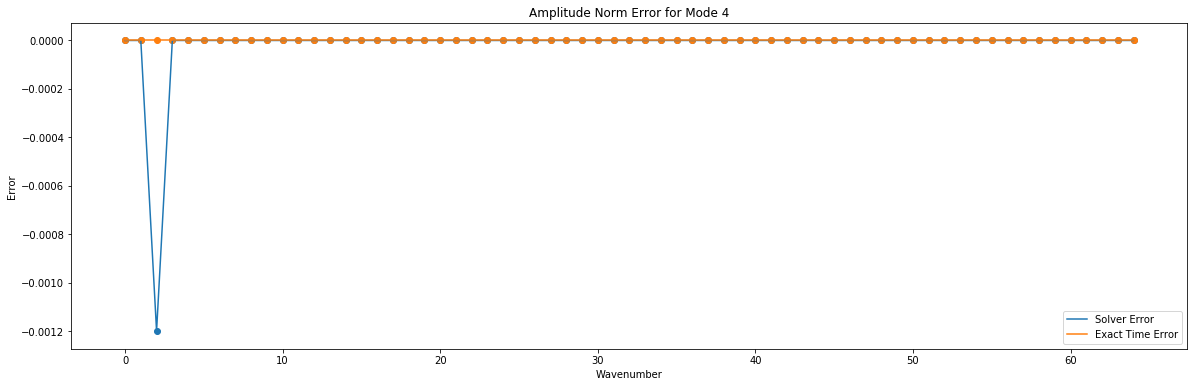


4
solvError:
[ 0.00000000e+00  0.00000000e+00 -1.20019974e-03 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

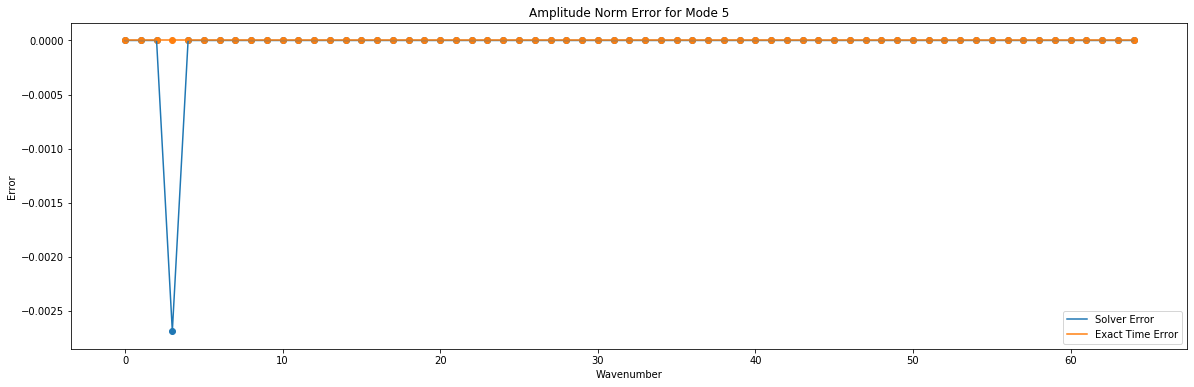


5
solvError:
[ 0.00000000e+00  0.00000000e+00 -1.00000008e-10 -2.68761737e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

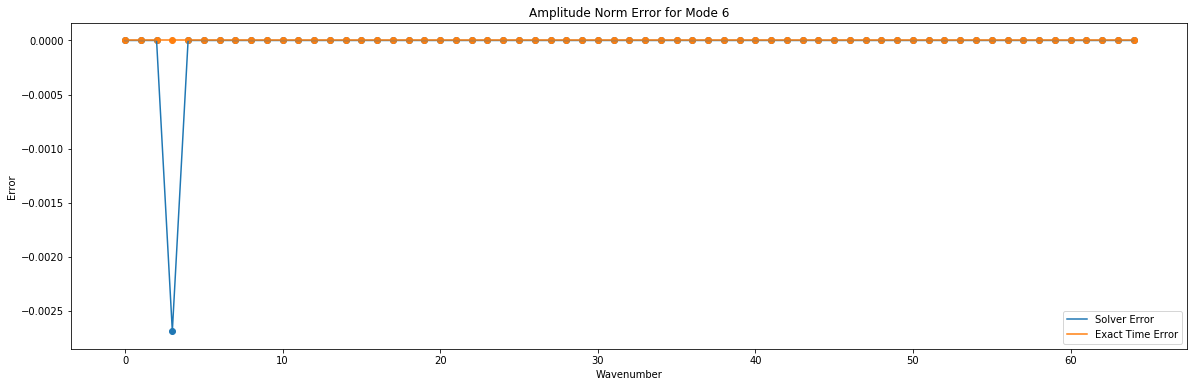


6
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00 -2.68761737e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

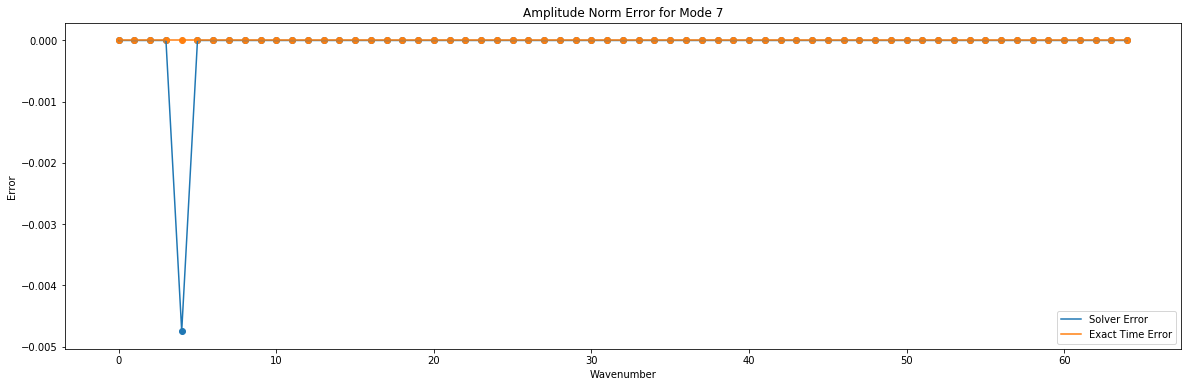


7
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.74626570e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

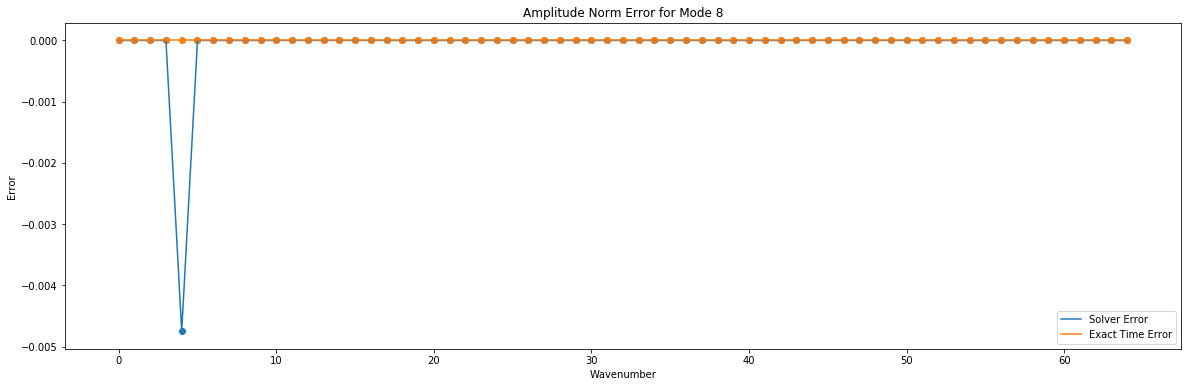


8
solvError:
[ 0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -4.74626570e-03  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

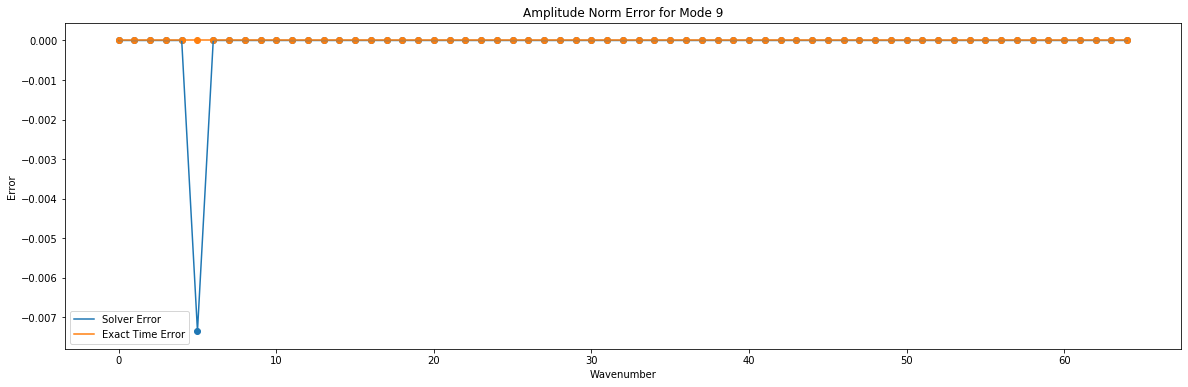


9
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.35288849e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

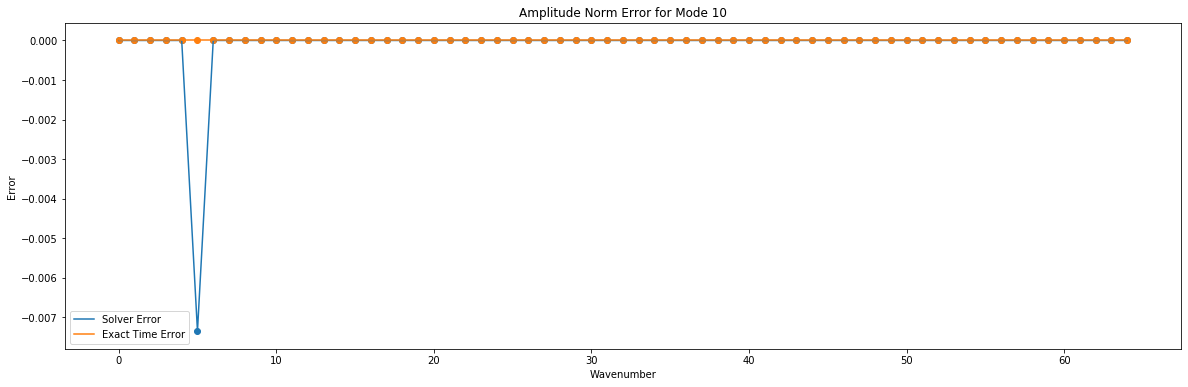


10
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.35288849e-03  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

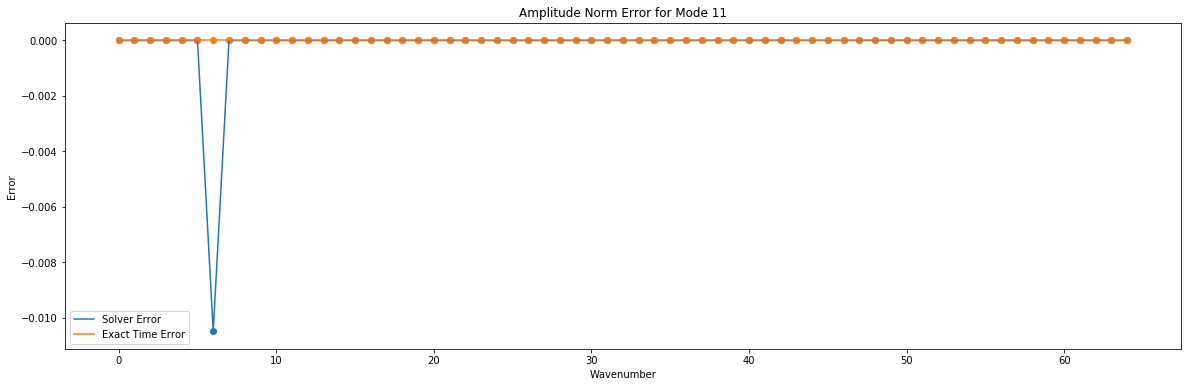


11
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.04782523e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

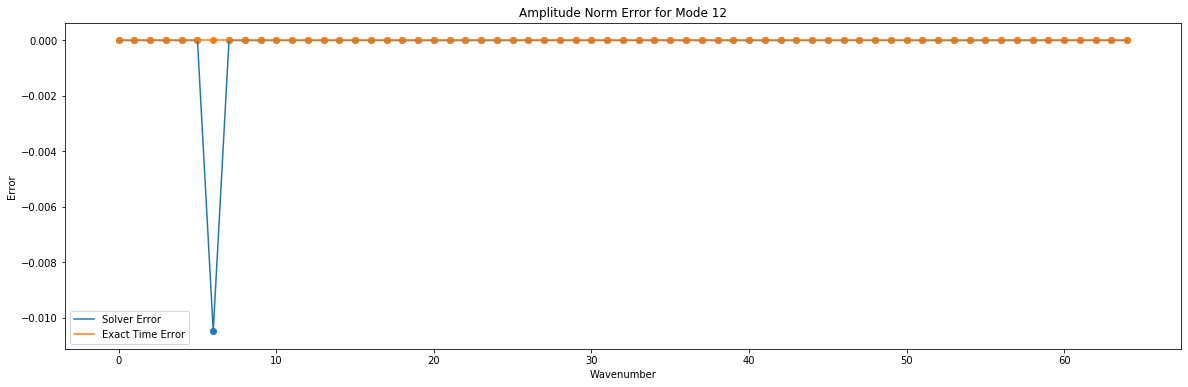


12
solvError:
[-5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.04782523e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

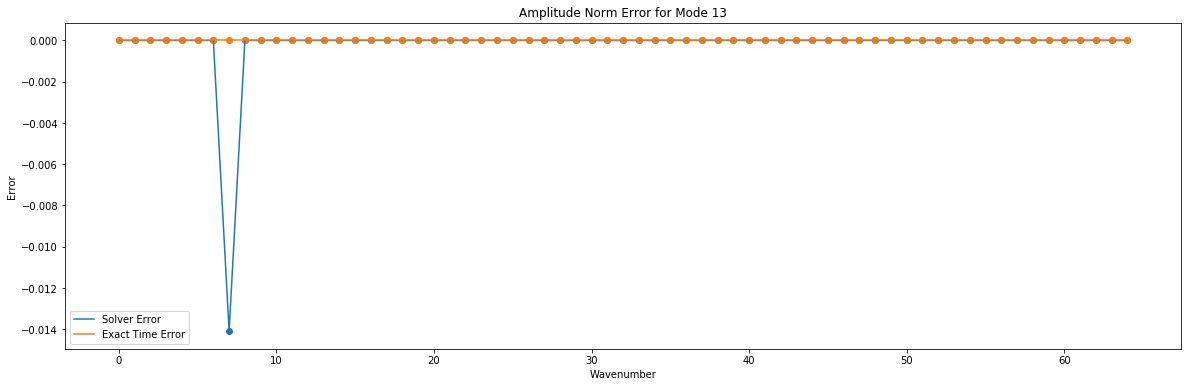


13
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.40876162e-02  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

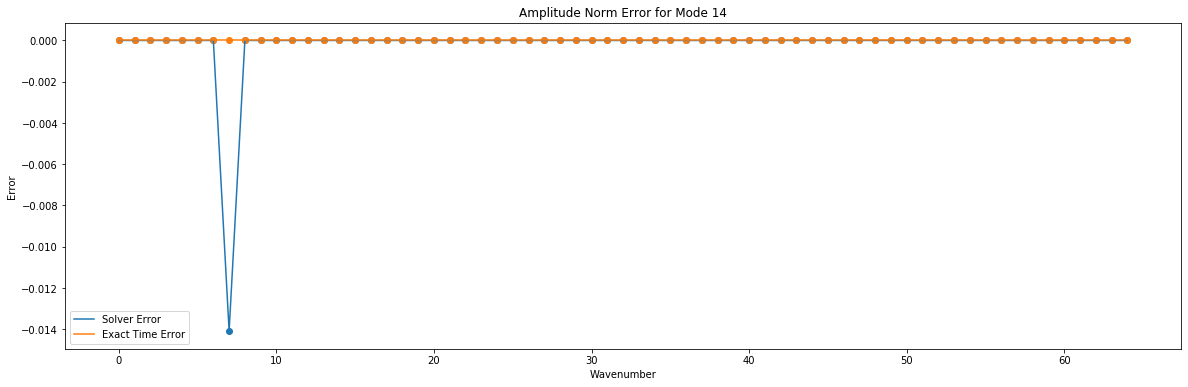


14
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.40876162e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

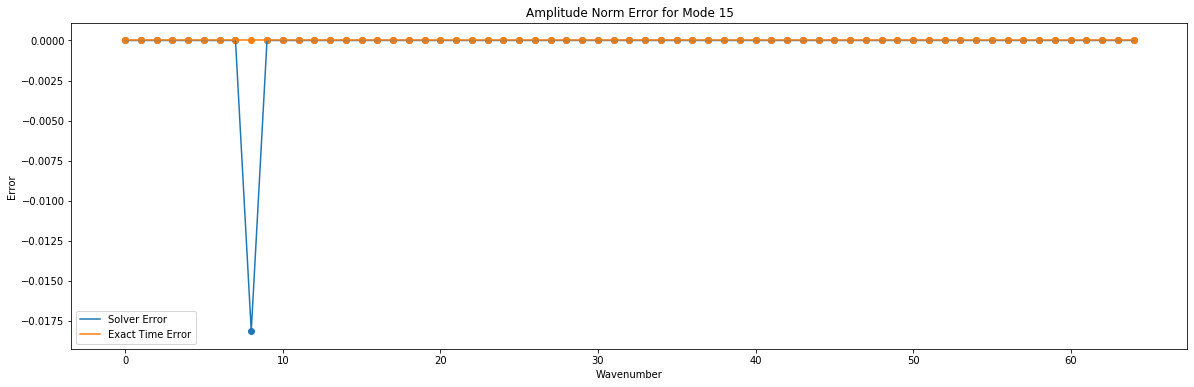


15
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.81412733e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

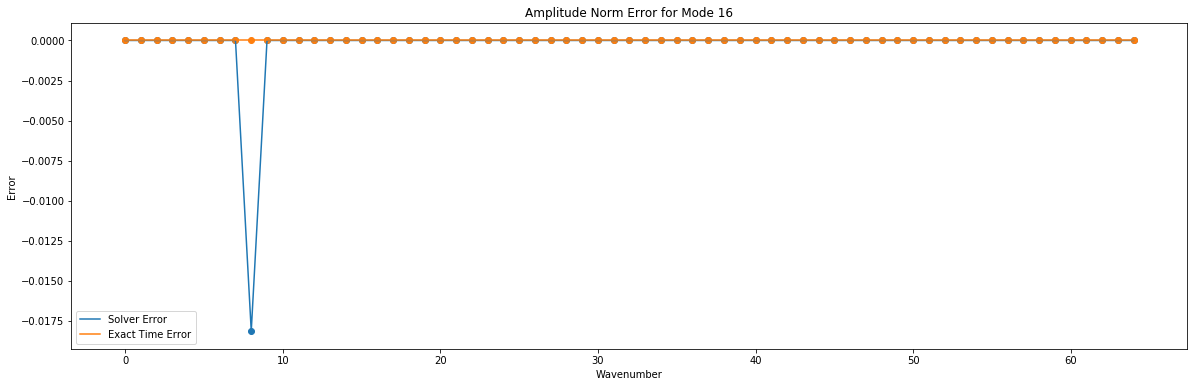


16
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.81412733e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

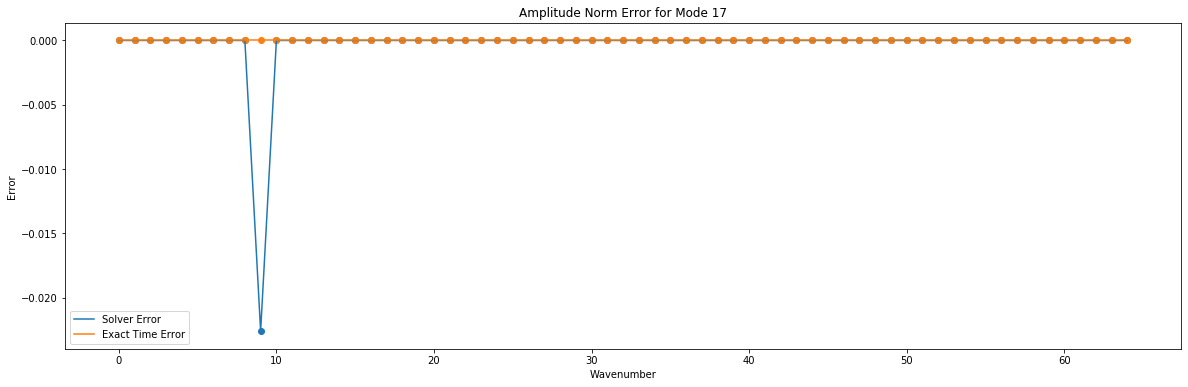


17
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -2.25951494e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000

[ 0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.25951494e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.0000

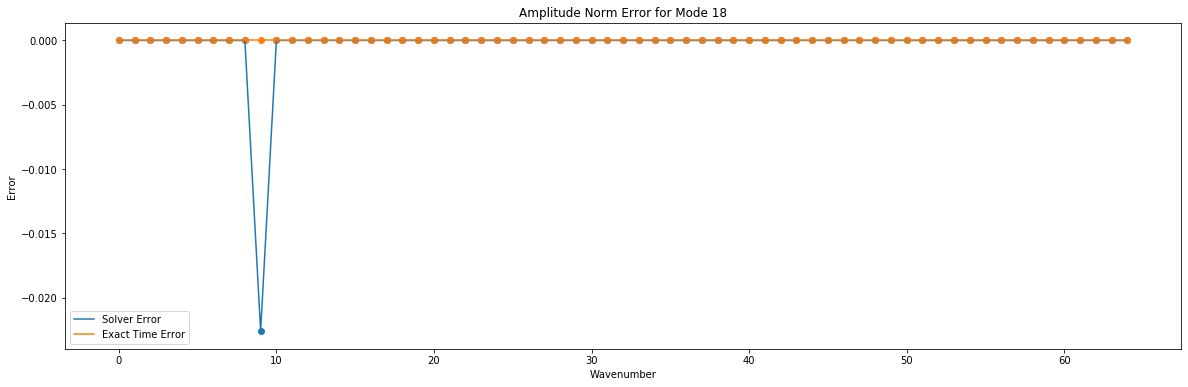


18
solvError:
[ 0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.25951494e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000

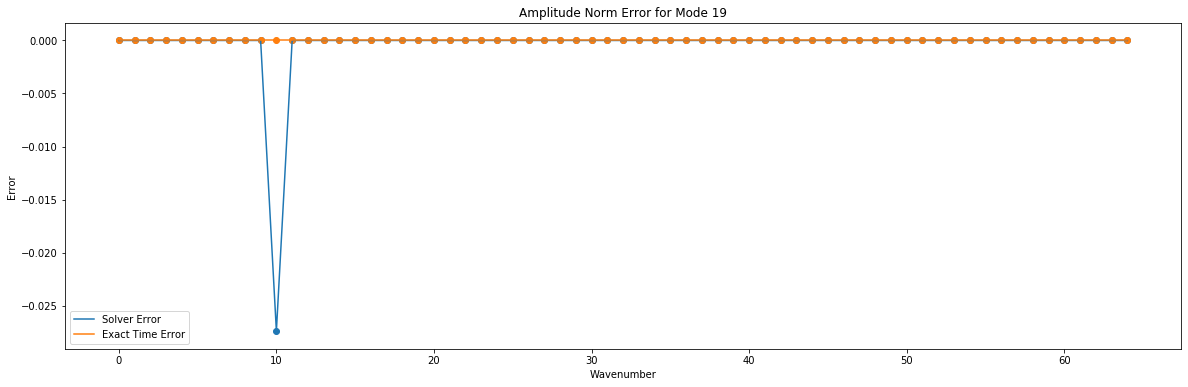


19
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.74014410e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

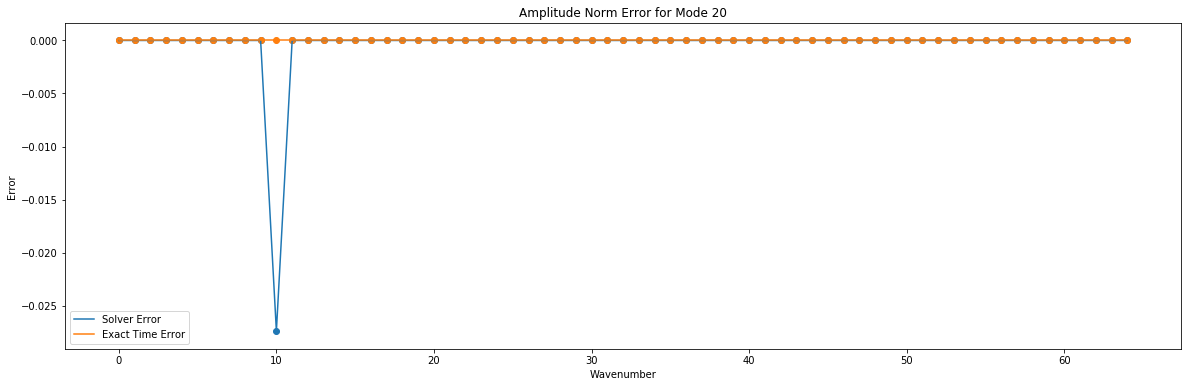


20
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -2.74014410e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

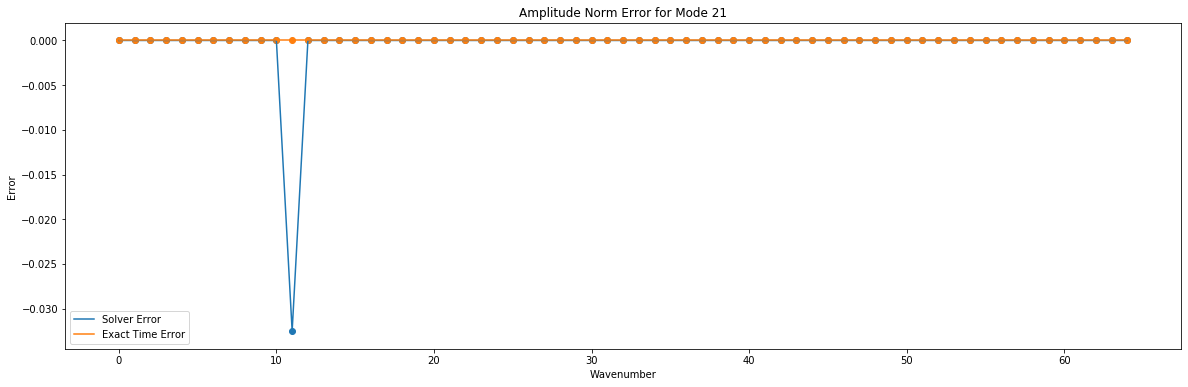


21
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.25092774e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

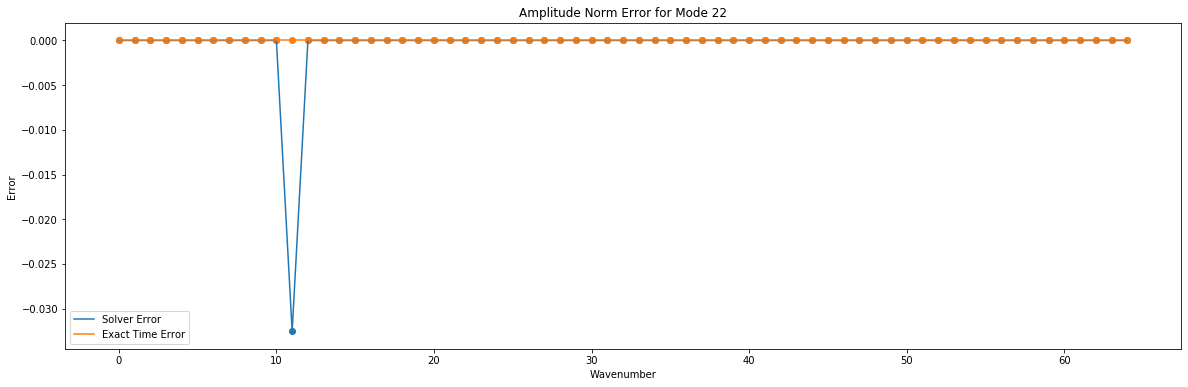


22
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.25092774e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

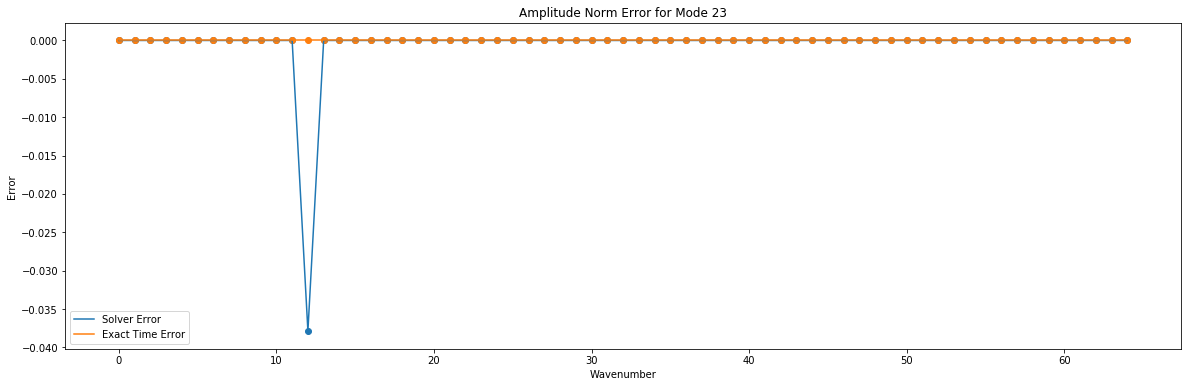


23
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -3.78653915e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000

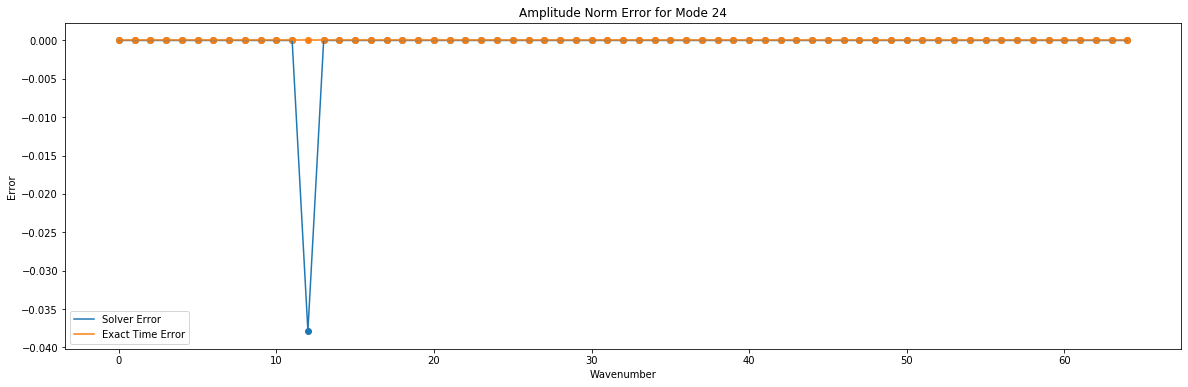


24
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -3.78653915e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000

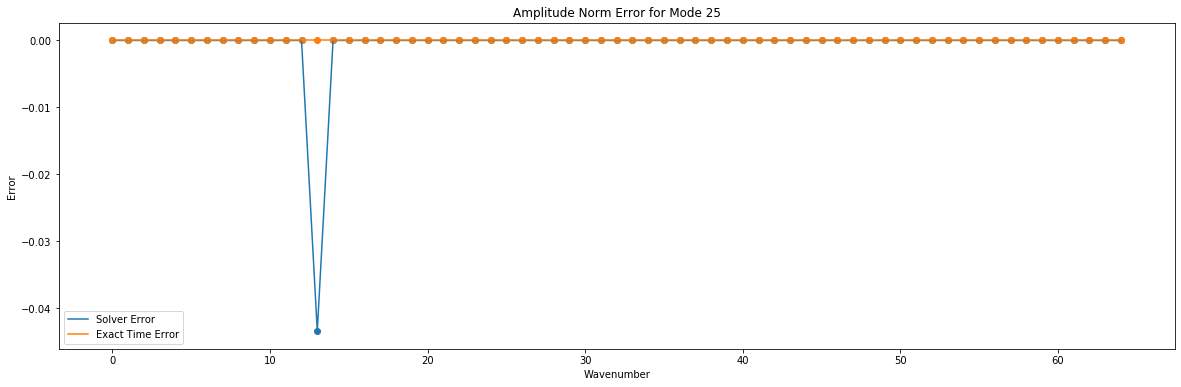


25
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.34147859e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000

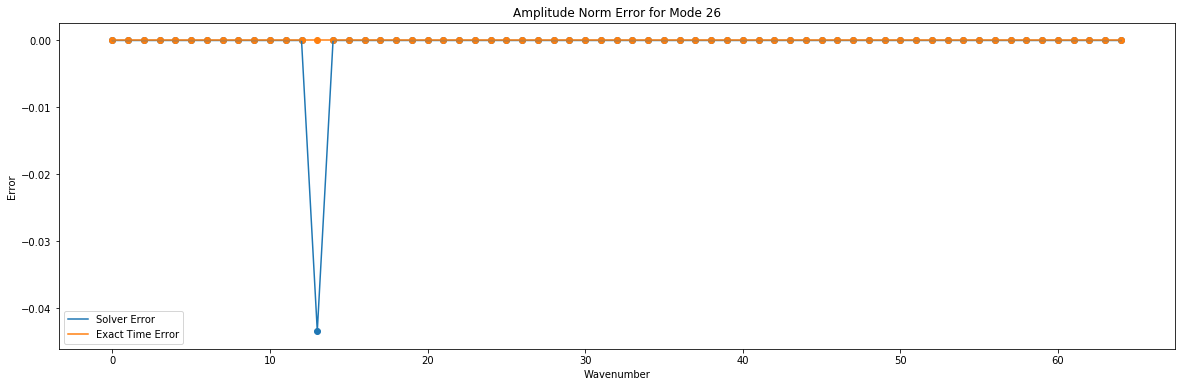


26
solvError:
[-5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.34147859e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000

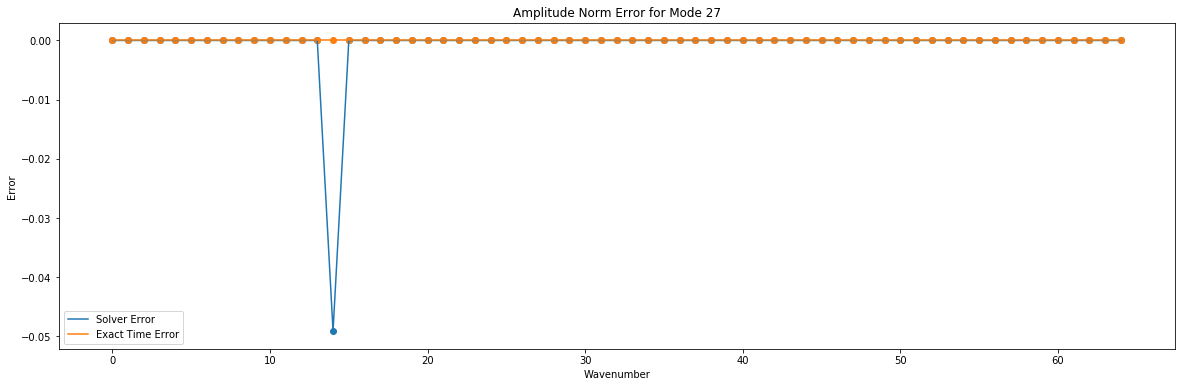


27
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.91013820e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

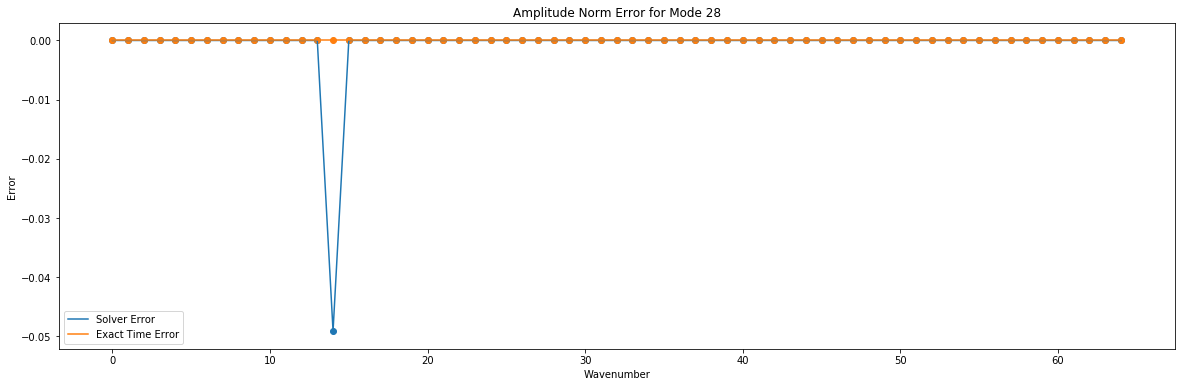


28
solvError:
[-5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.91013820e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

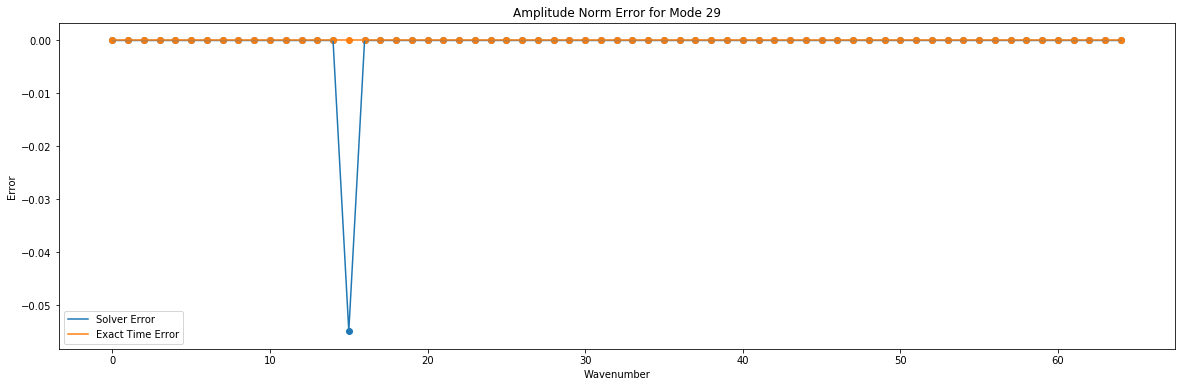


29
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.48686446e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -2.00000017e-10 -1.00000008e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

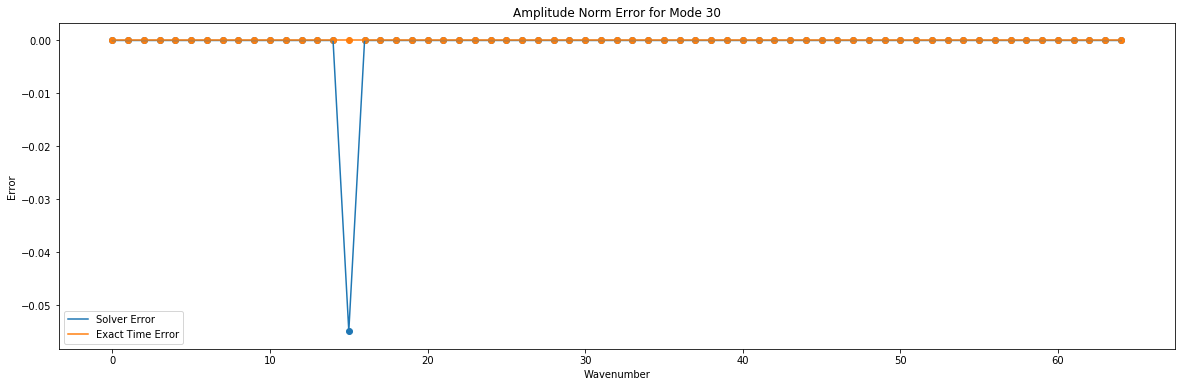


30
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.48686446e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -2.00000017e-10 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

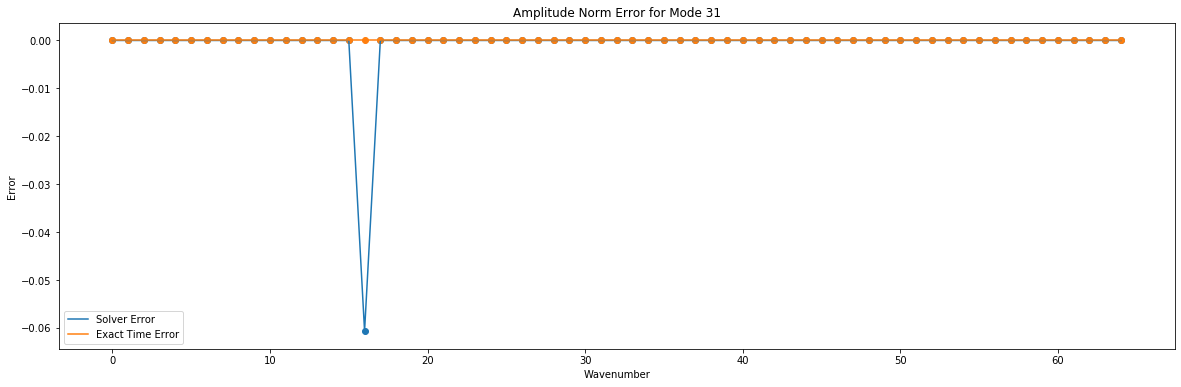


31
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.06601718e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000

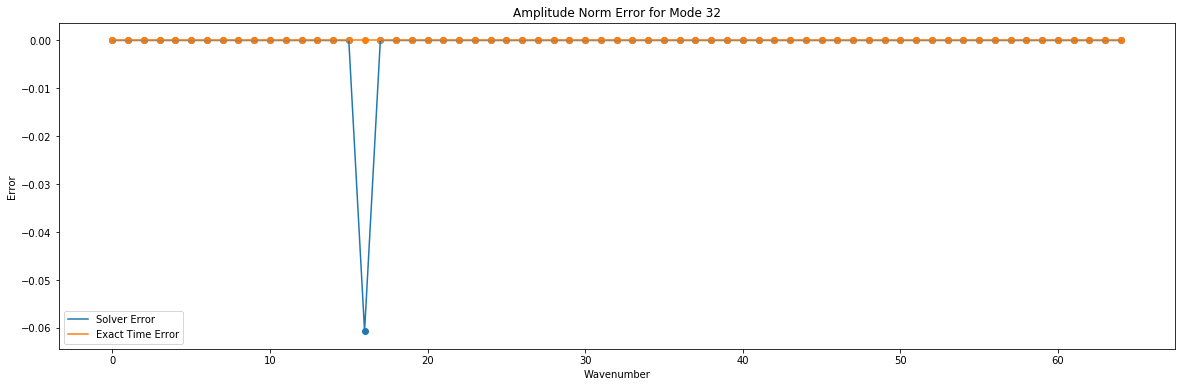


32
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.06601718e-02  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

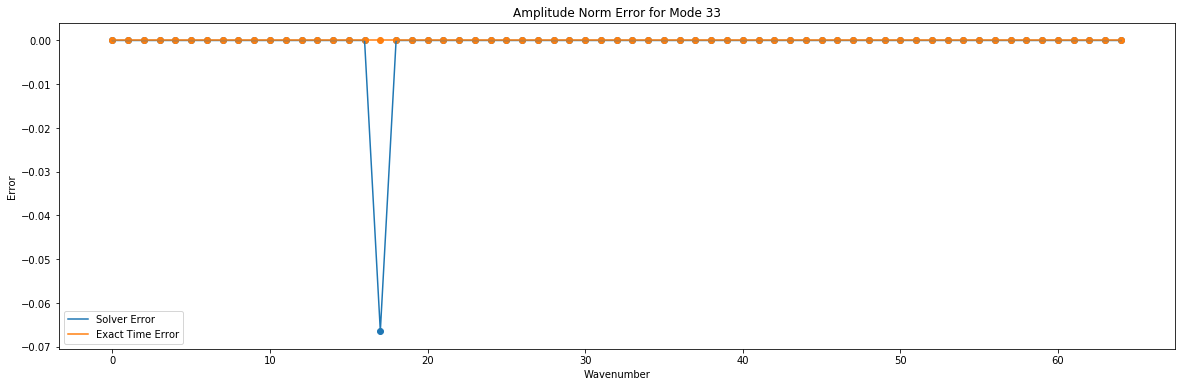


33
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.64202467e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000

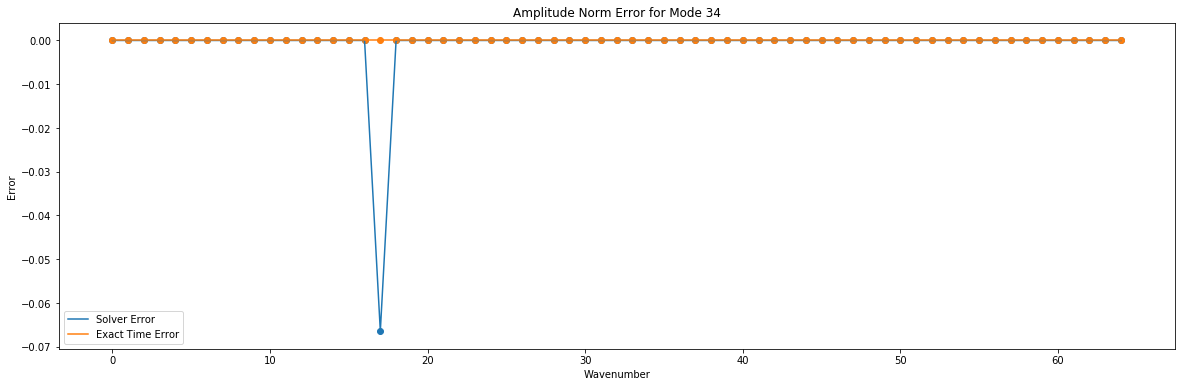


34
solvError:
[ 0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.64202467e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

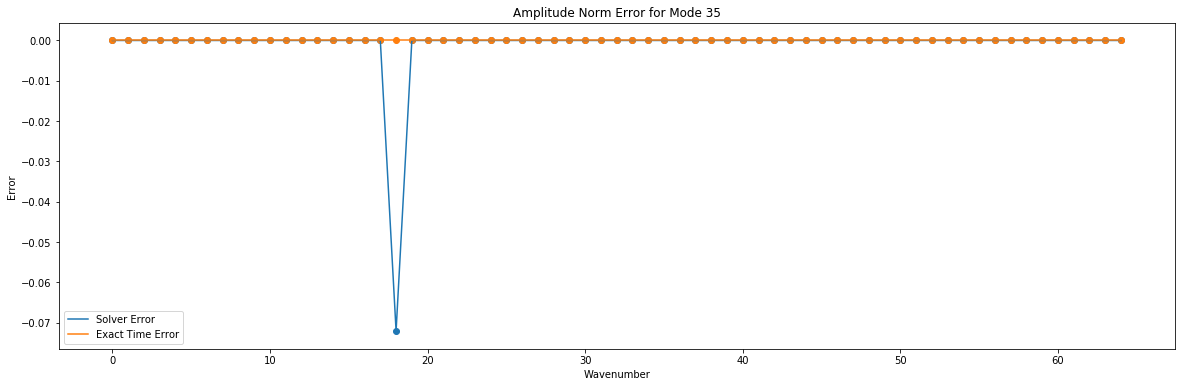


35
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.20943476e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -2.50000021e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000

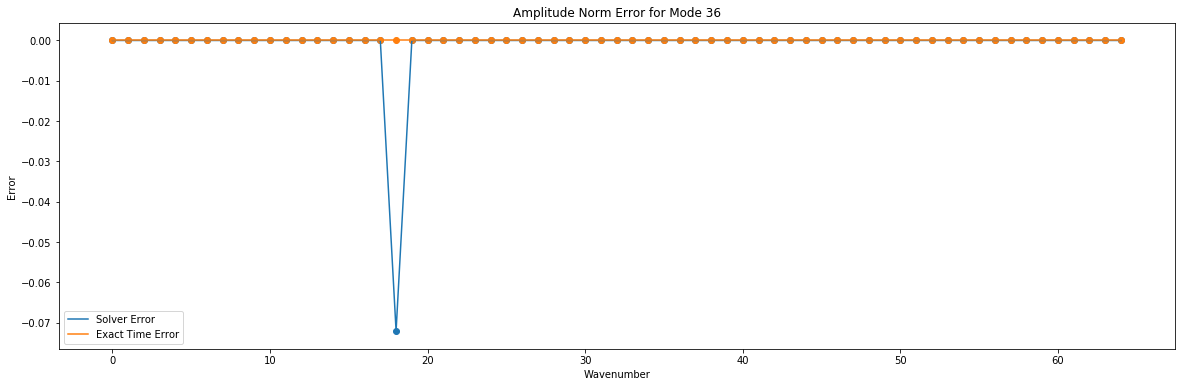


36
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -7.20943476e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

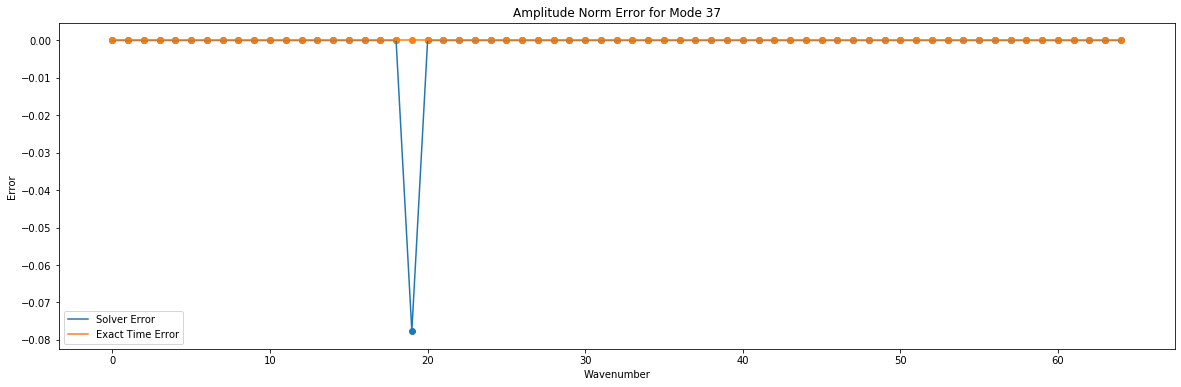


37
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.76296139e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

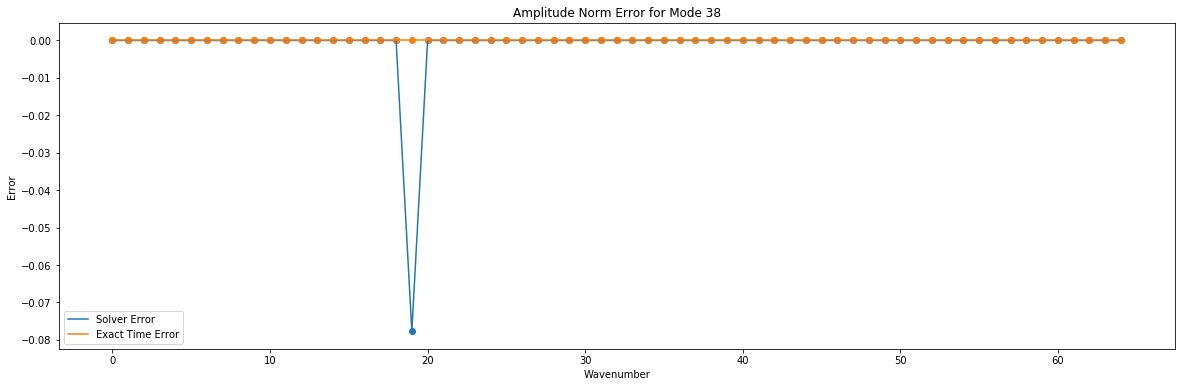


38
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.76296139e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000

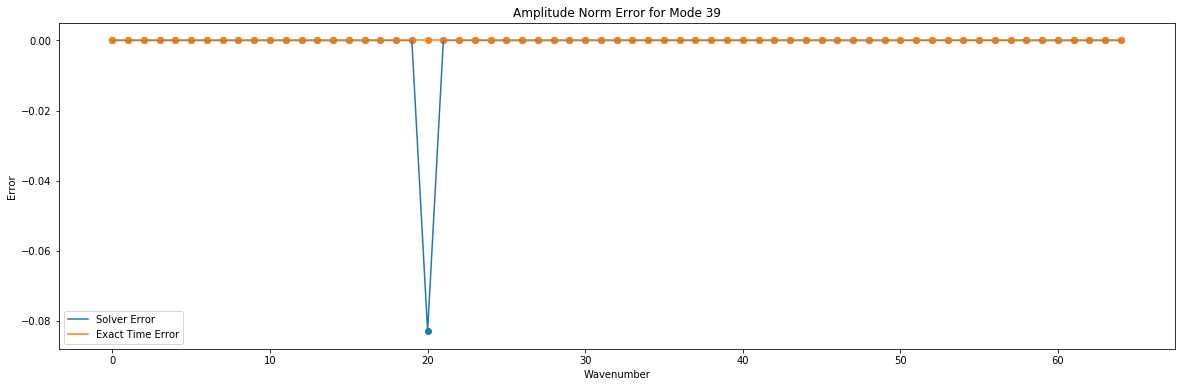


39
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -8.29752671e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

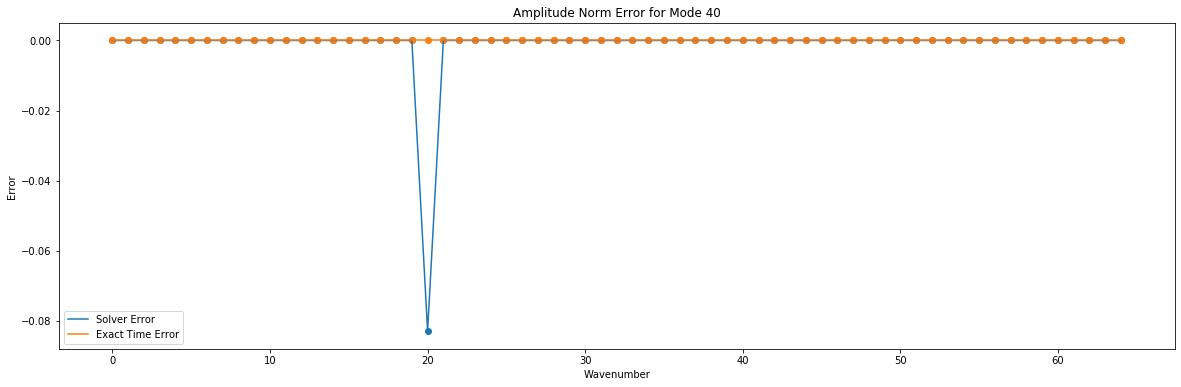


40
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.29752671e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

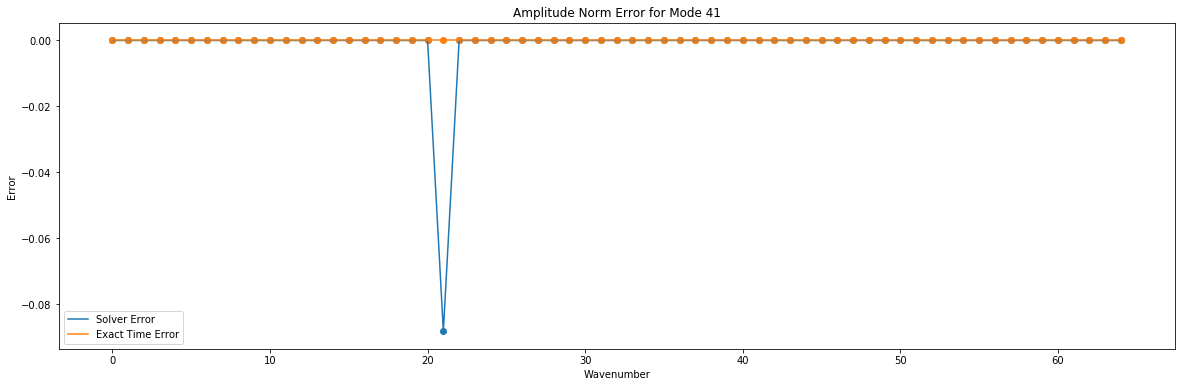


41
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.80829895e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -2.00000017e-10  0.00000000e+00  0.00000

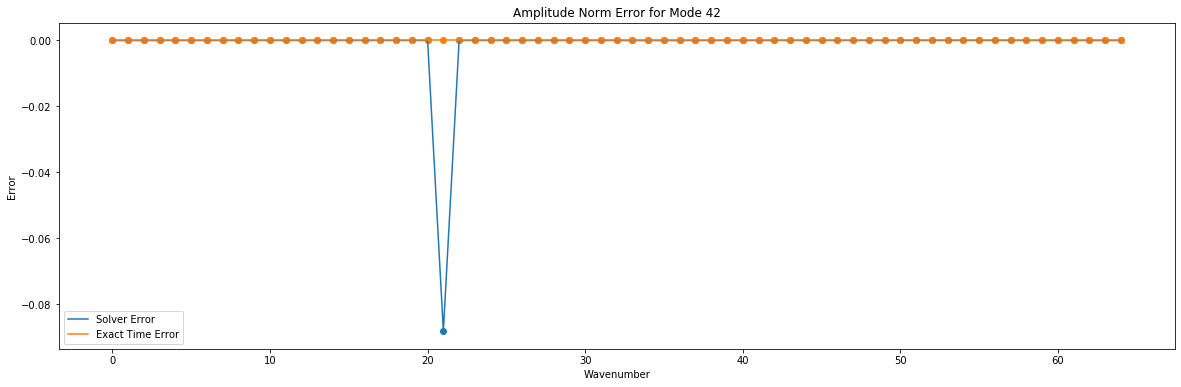


42
solvError:
[-5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -8.80829895e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -1.00000008e-10  0.00000

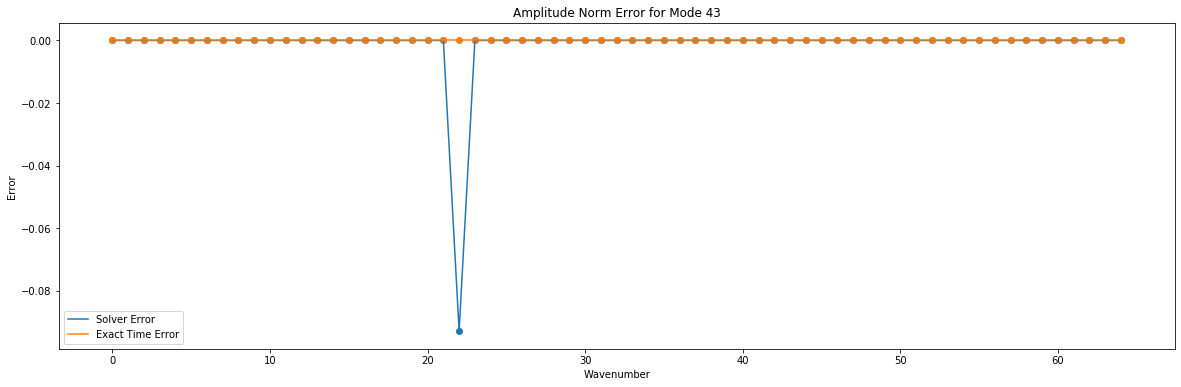


43
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.29072601e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

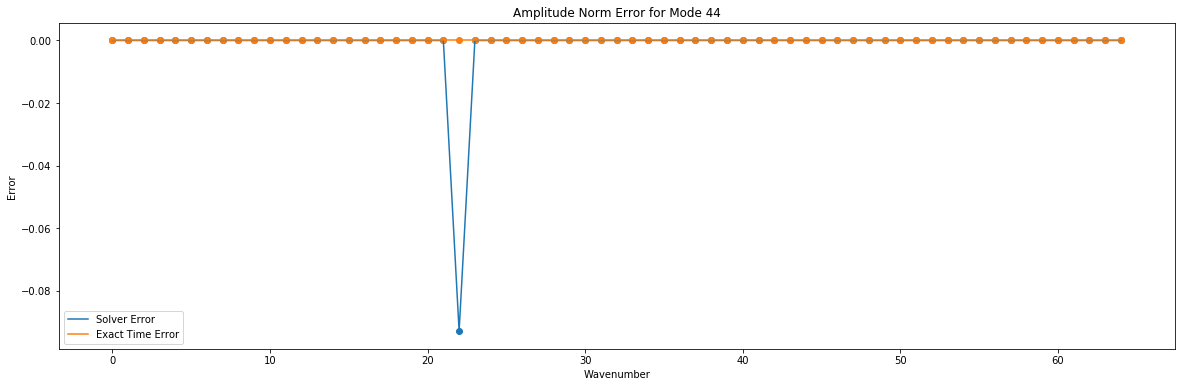


44
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.29072601e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  1.11022302e-16 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.0000

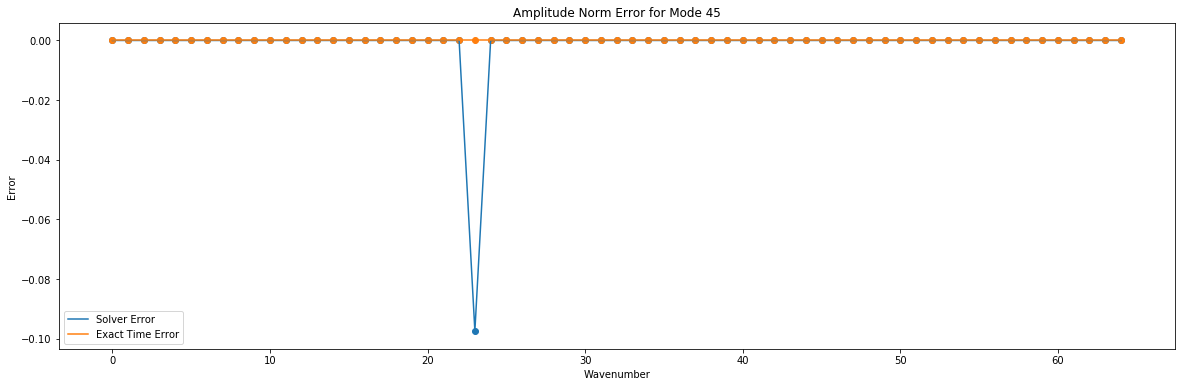


45
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.74056499e-02 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000

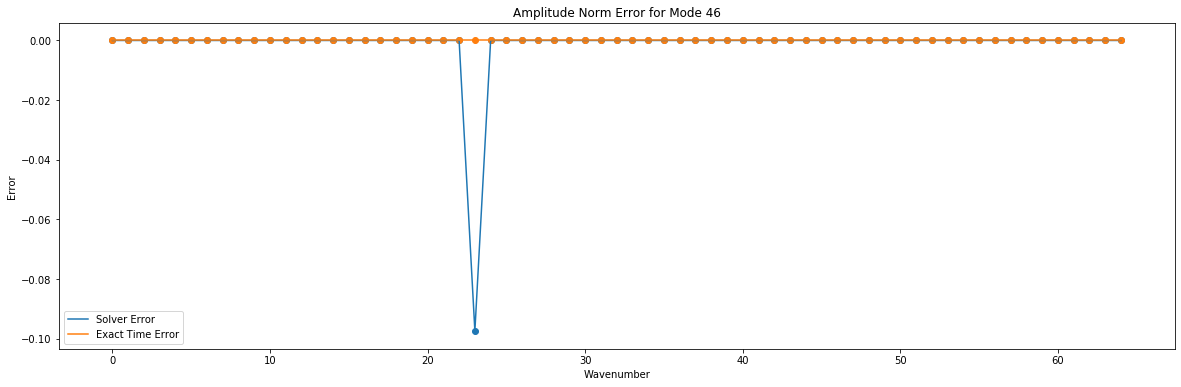


46
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -9.74056499e-02 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10 -5.00000

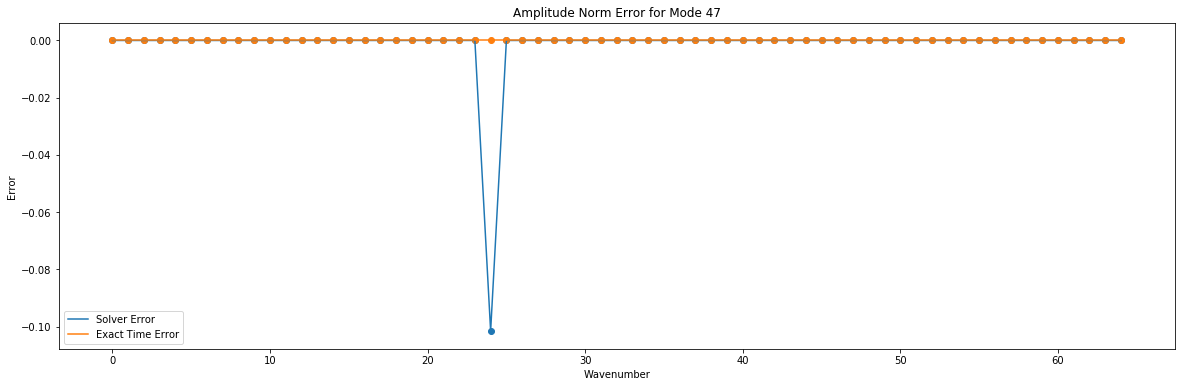


47
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.01539081e-01 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -1.00000

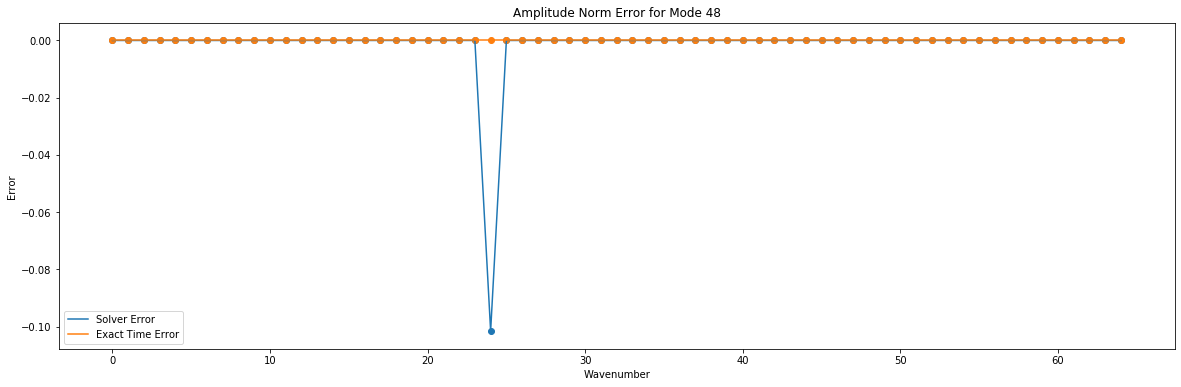


48
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.01539081e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -2.00000017e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -1.00000008e-10 -5.00000041e-11 -2.50000021e-10 -5.00000041e-11 -5.00000

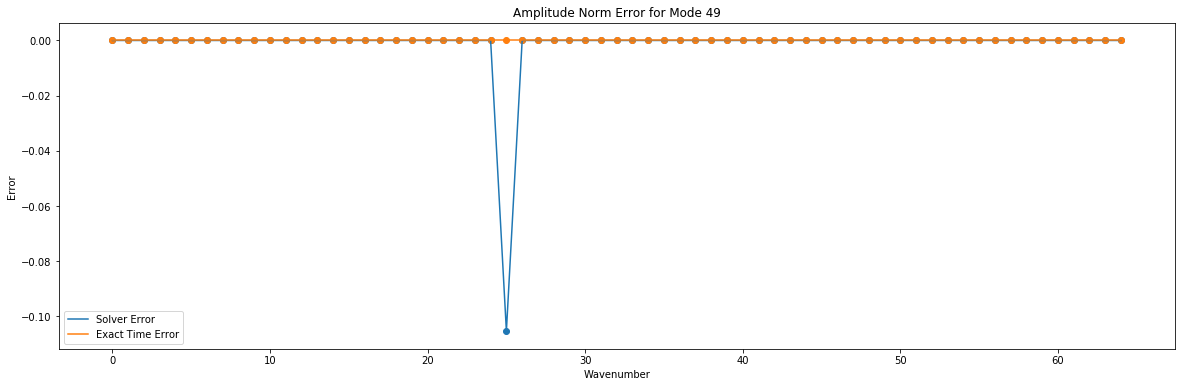


49
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.05272051e-01 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

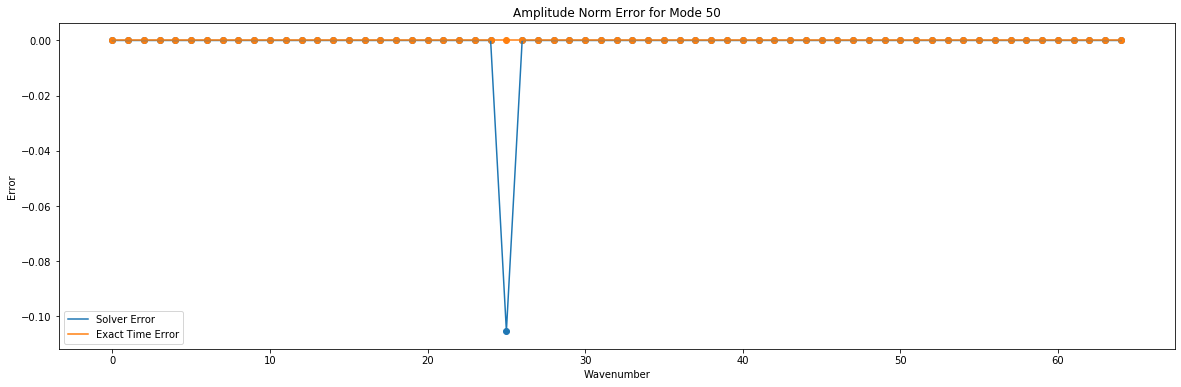


50
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.05272051e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

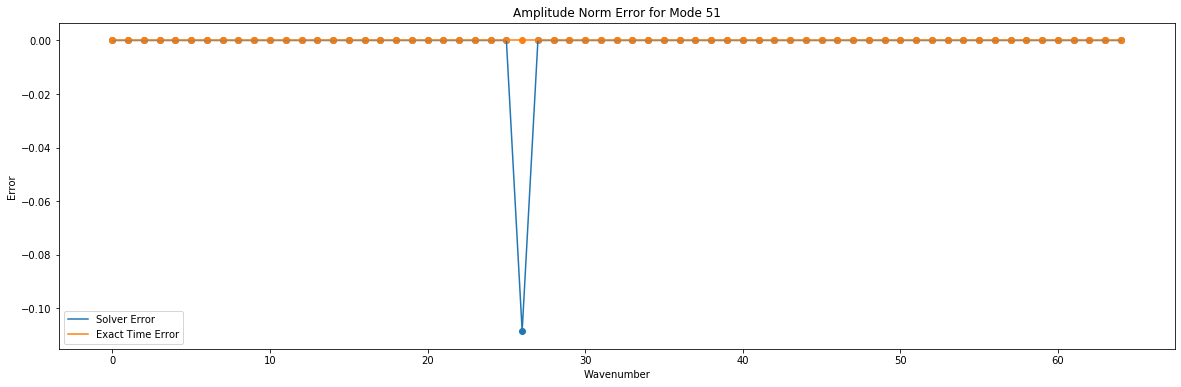


51
solvError:
[ 0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.08572822e-01 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -2.00000017e-10  0.00000000e+00 -2.00000017e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

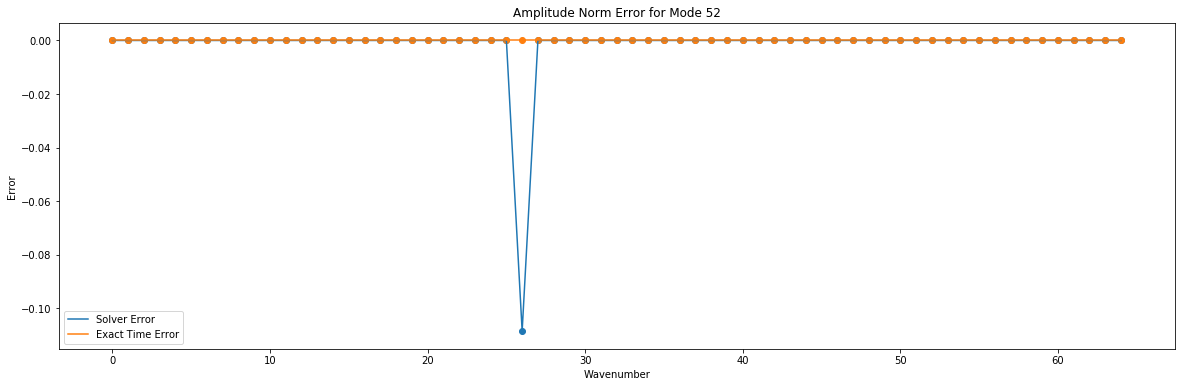


52
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.08572822e-01  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000

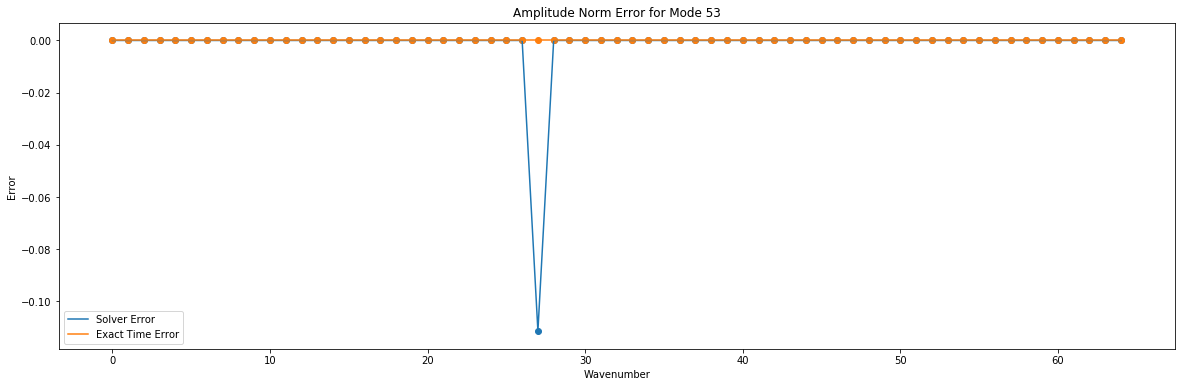


53
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11413586e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000

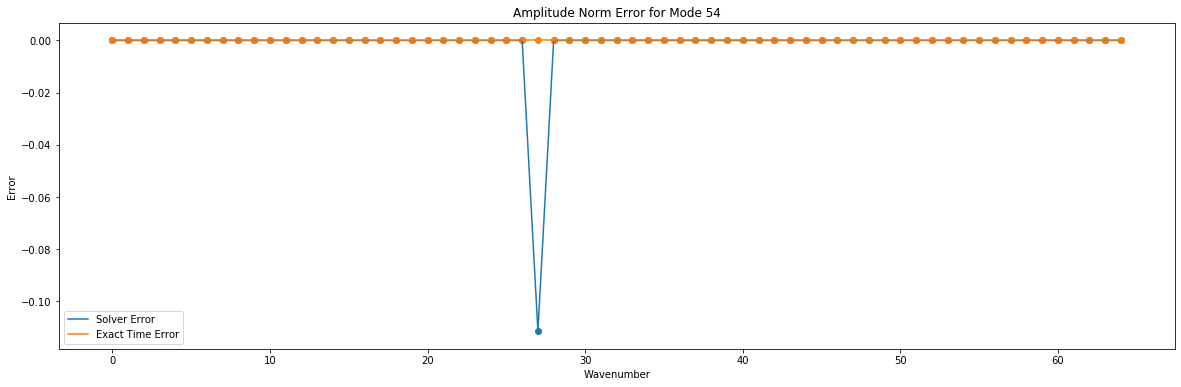


54
solvError:
[ 0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11413586e-01 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000

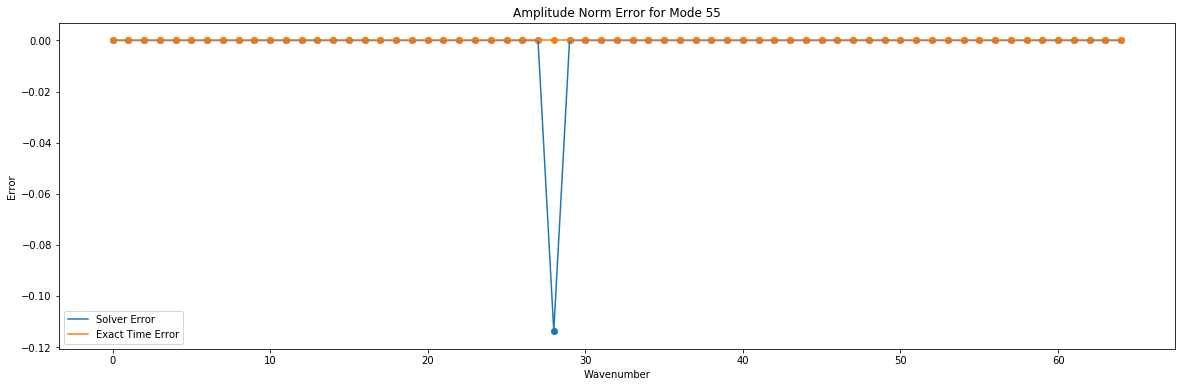


55
solvError:
[ 0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.13770596e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

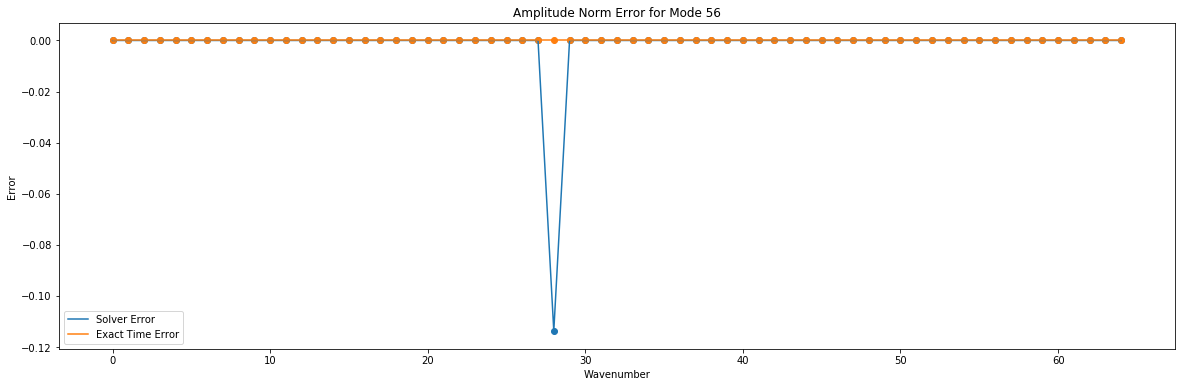


56
solvError:
[ 0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.13770596e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000

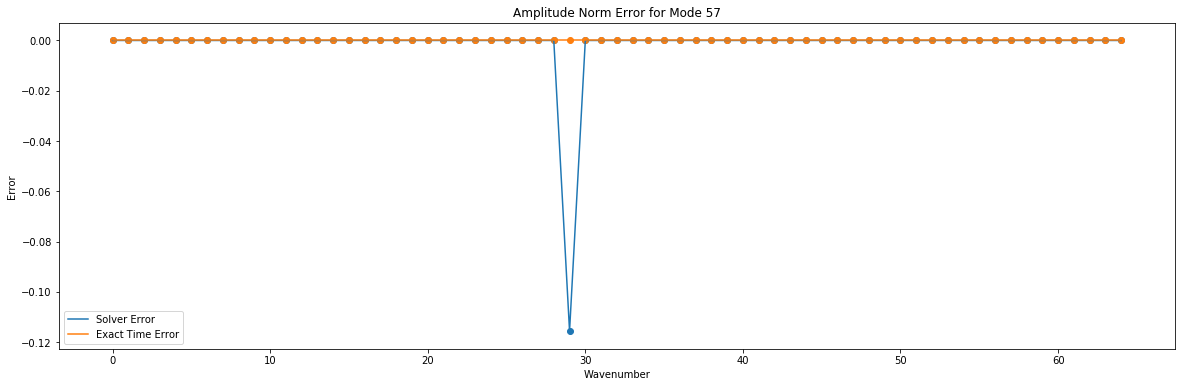


57
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.15624284e-01 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000

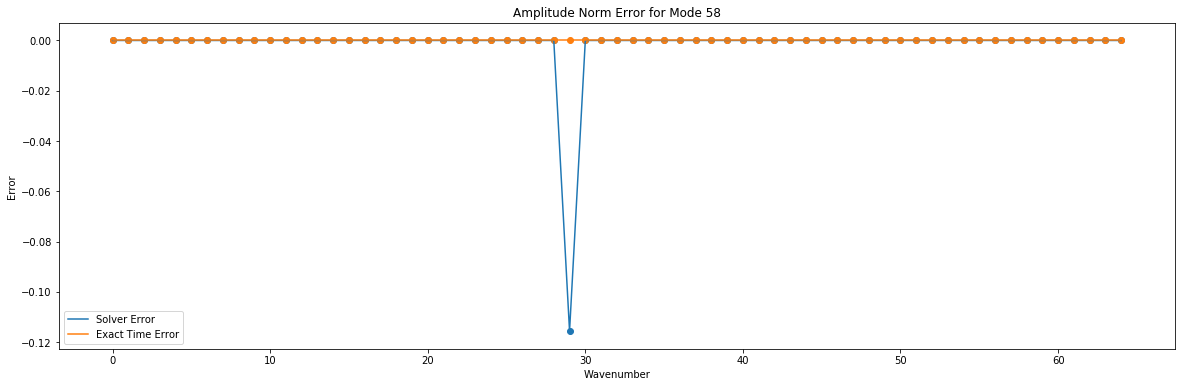


58
solvError:
[ 0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.15624284e-01 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000

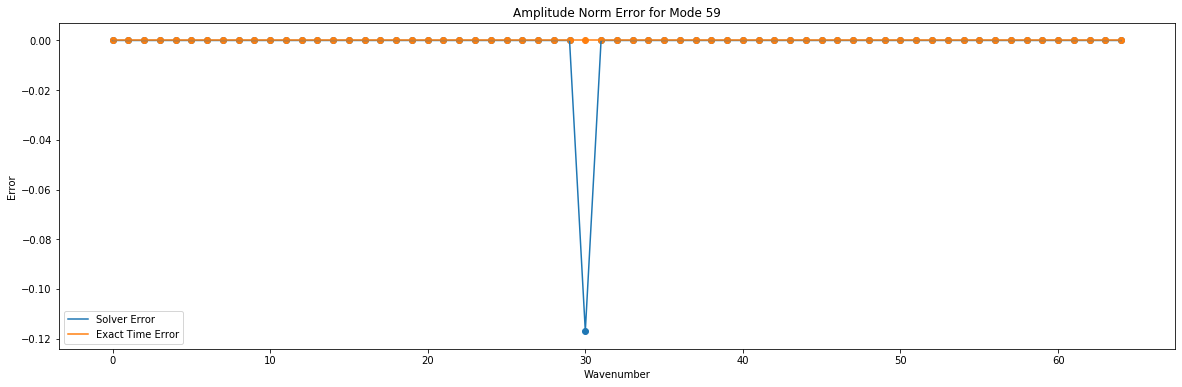


59
solvError:
[ 0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.16959337e-01  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -2.50000021e-10 -2.00000017e-10 -2.50000021e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

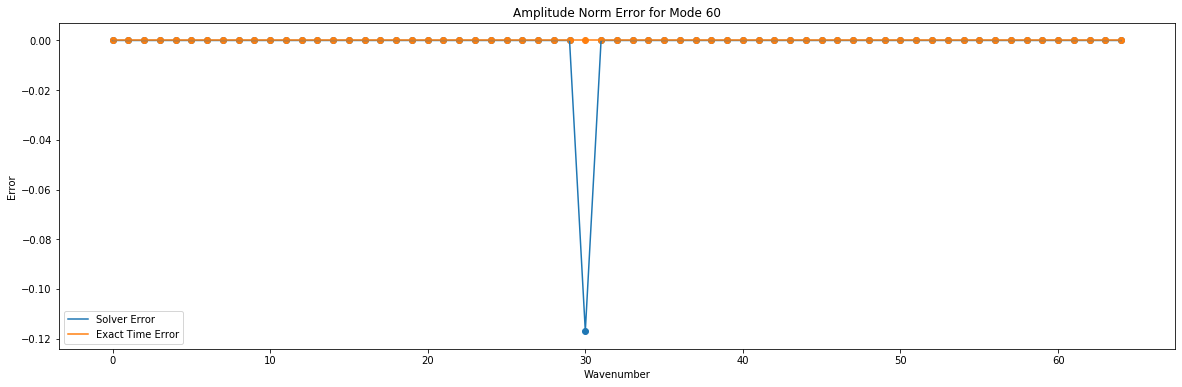


60
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.16959337e-01  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -1.00000008e-10 -2.00000017e-10 -1.00000008e-10 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

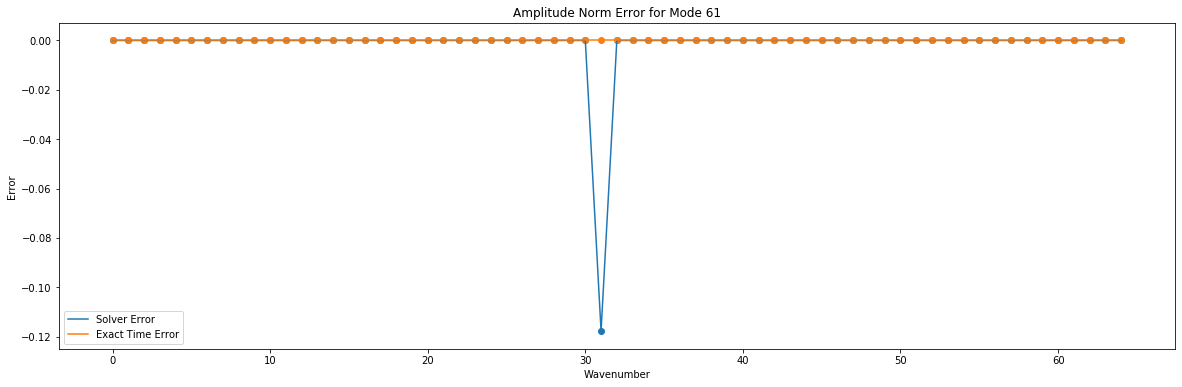


61
solvError:
[ 0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.17764774e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -2.00000017e-10 -1.00000008e-10 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000

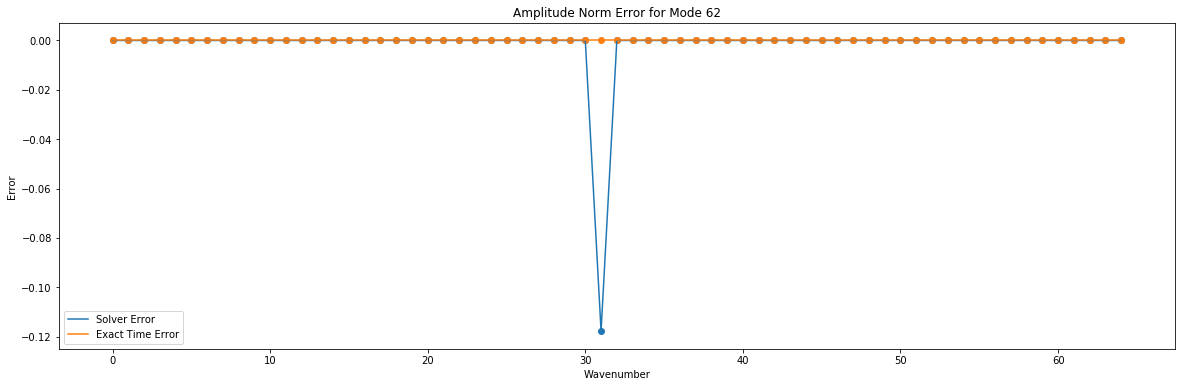


62
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.17764774e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -2.00000017e-10 -2.50000021e-10 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

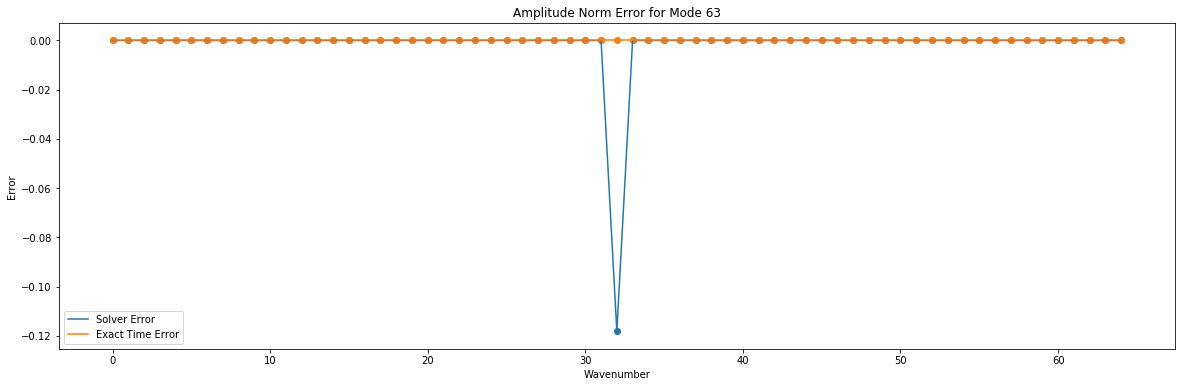


63
solvError:
[-5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.18033989e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000

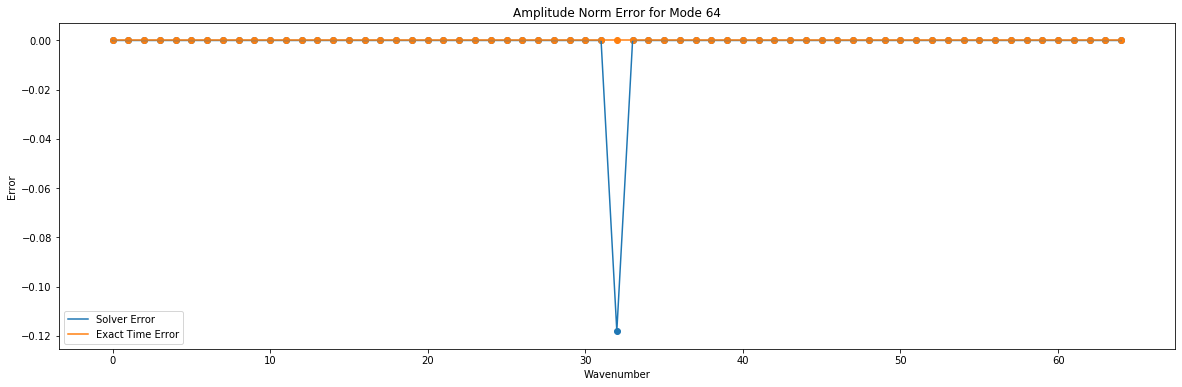


64
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18033989e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

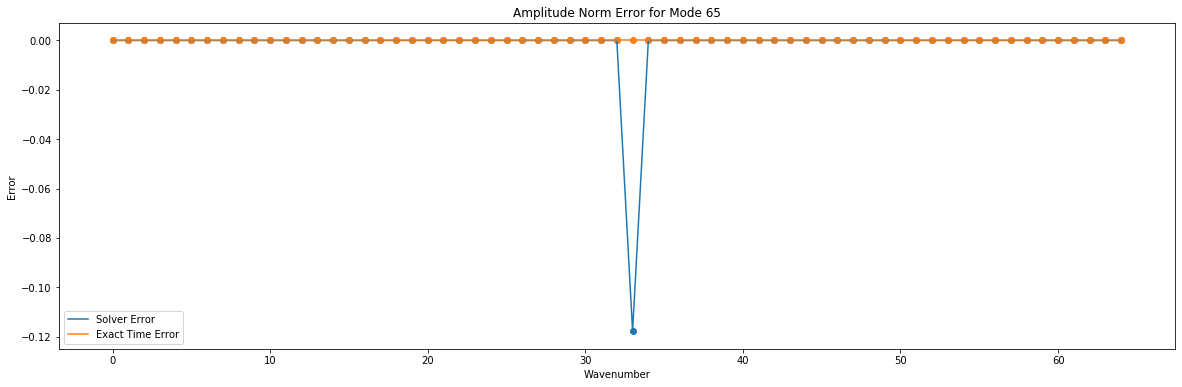


65
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.17764774e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

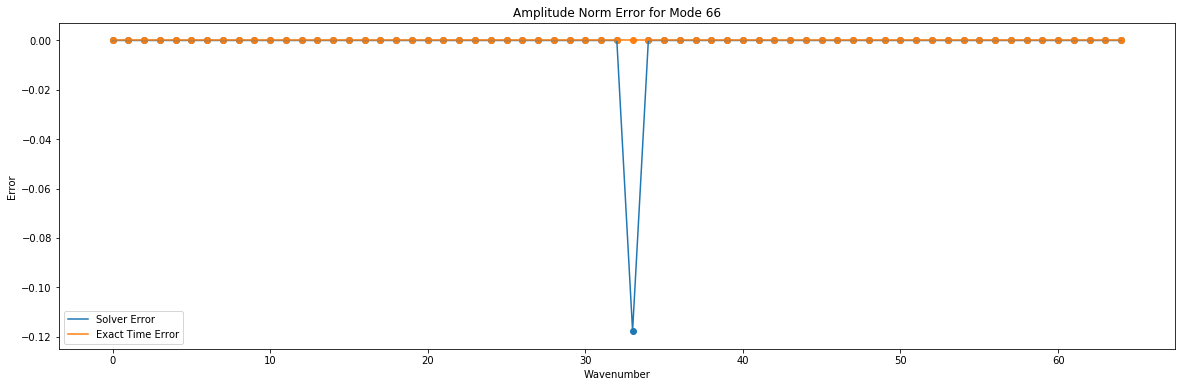


66
solvError:
[ 0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.17764774e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

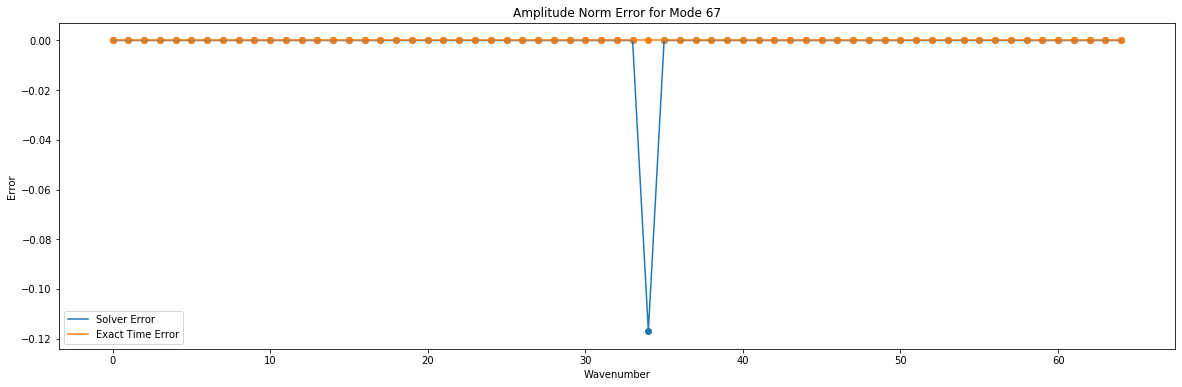


67
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.16959337e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

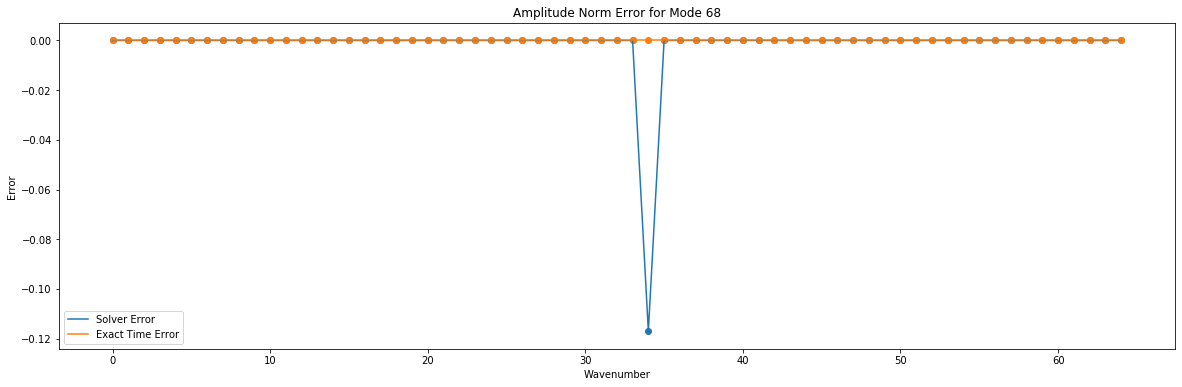


68
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.16959337e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -1.00000008e-10 -1.00000008e-10  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000

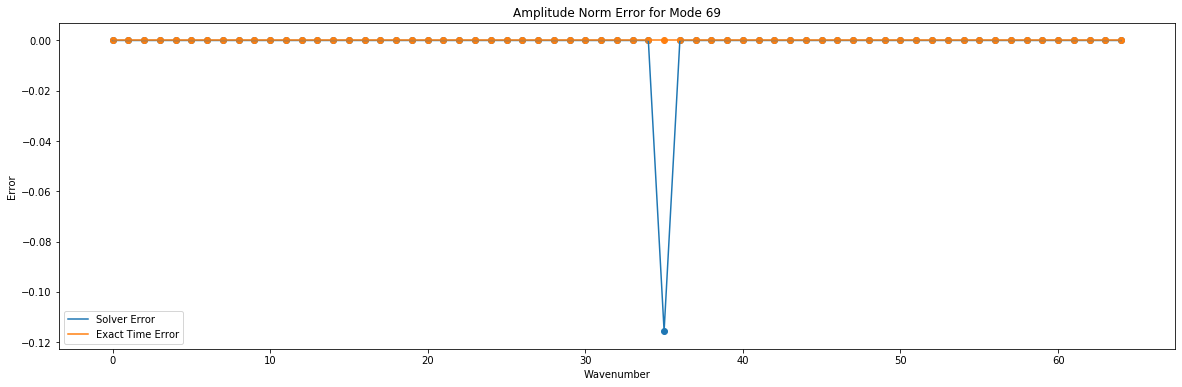


69
solvError:
[-5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.15624284e-01  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.00000017e-10 -2.00000017e-10 -2.00000017e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000

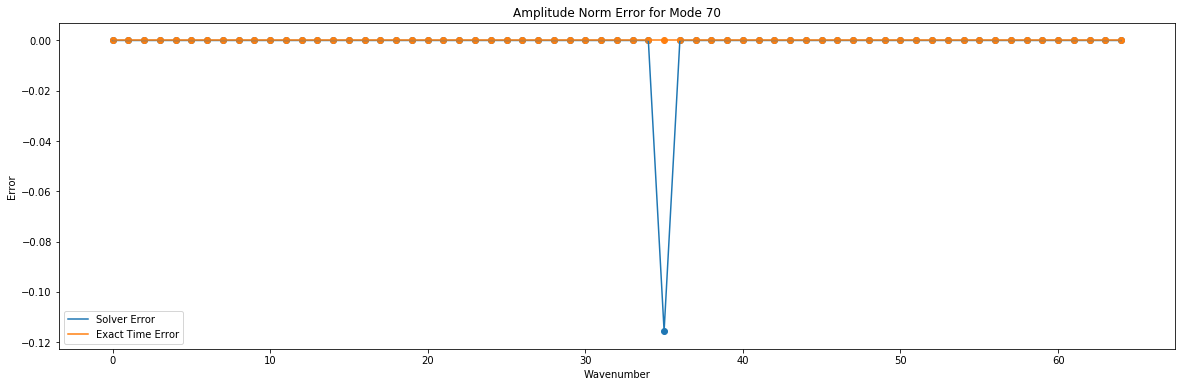


70
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.15624284e-01  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.50000021e-10 -2.00000017e-10 -2.00000017e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000

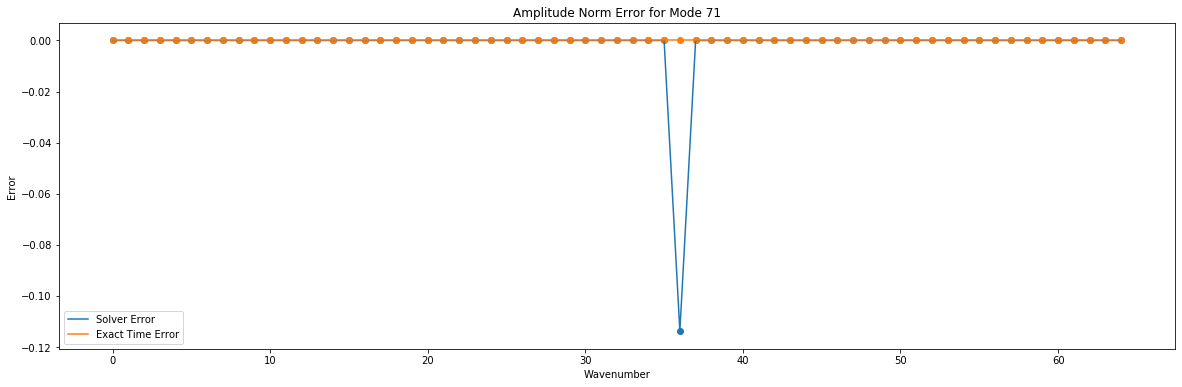


71
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.13770596e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

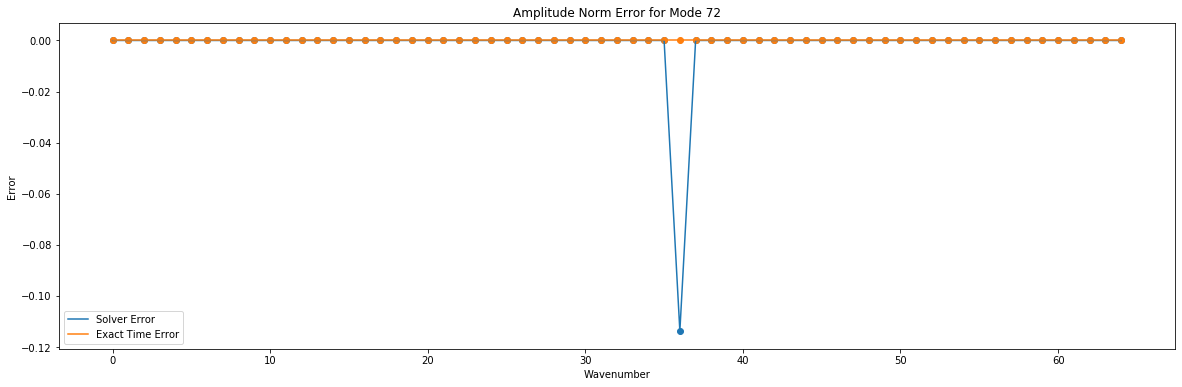


72
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00 -1.13770596e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

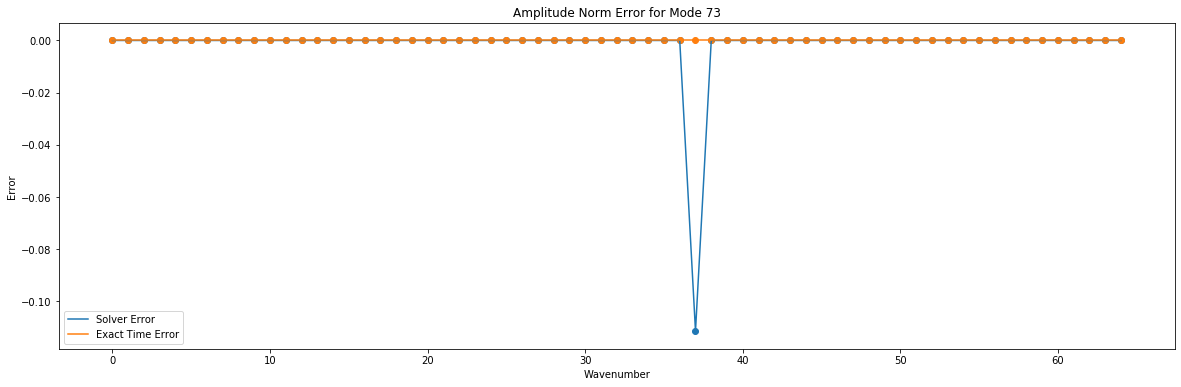


73
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11 -1.11413586e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000

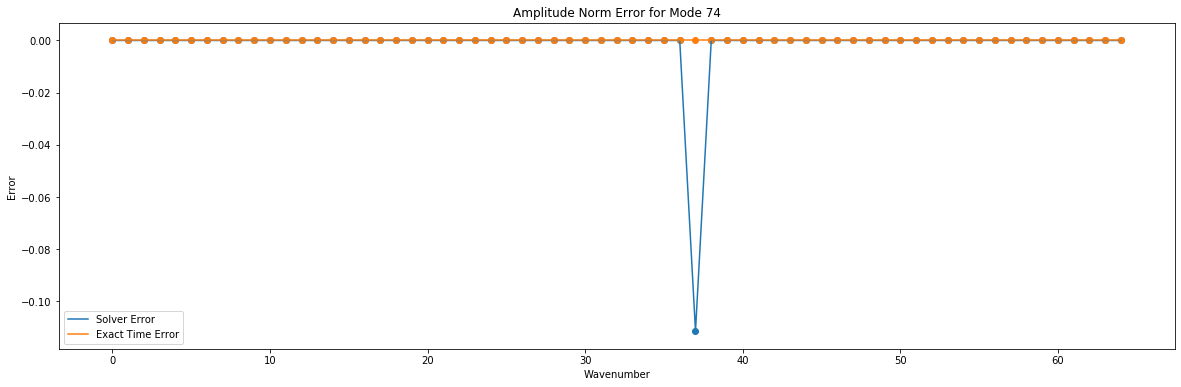


74
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -1.11413586e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000

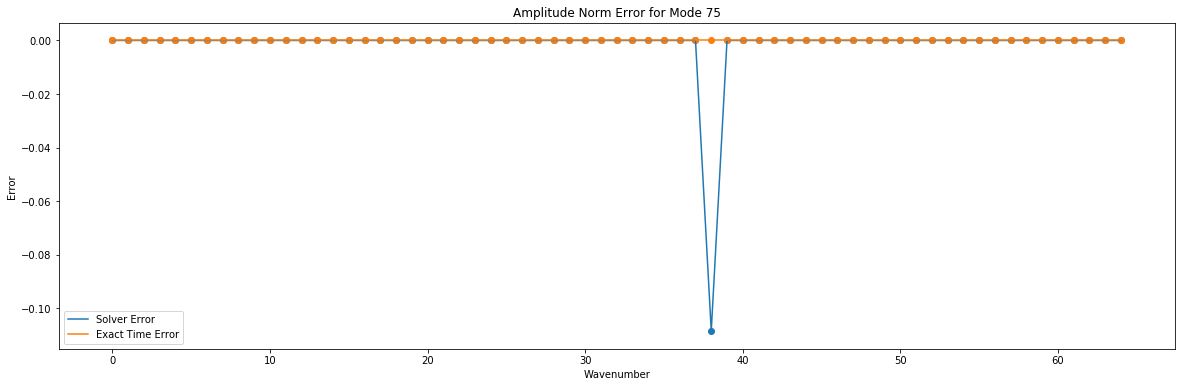


75
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.08572822e-01 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

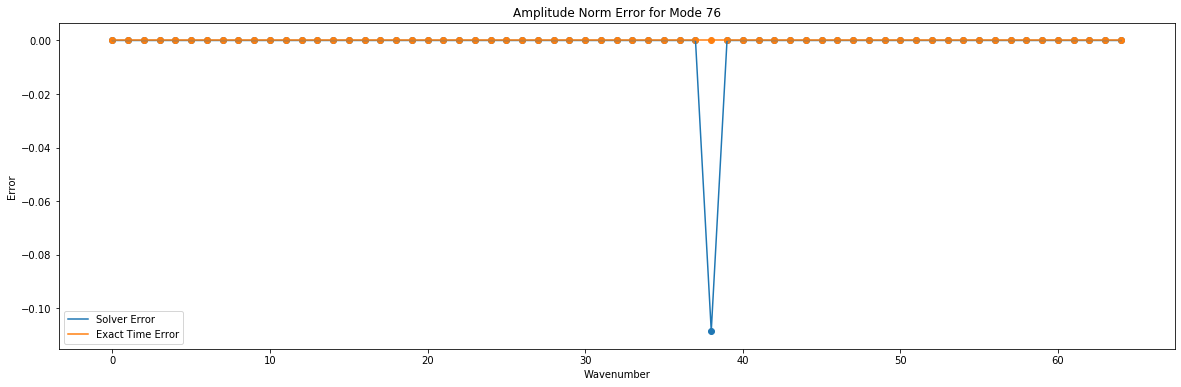


76
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.08572822e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000

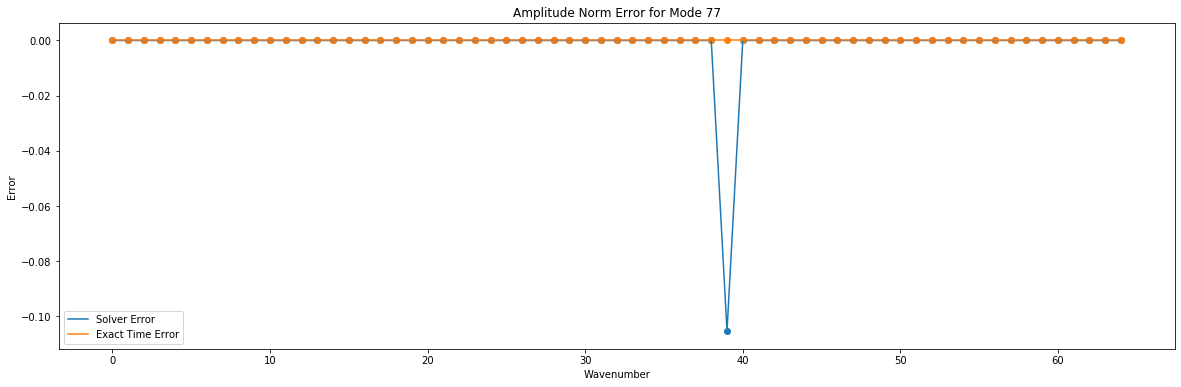


77
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.05272051e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000

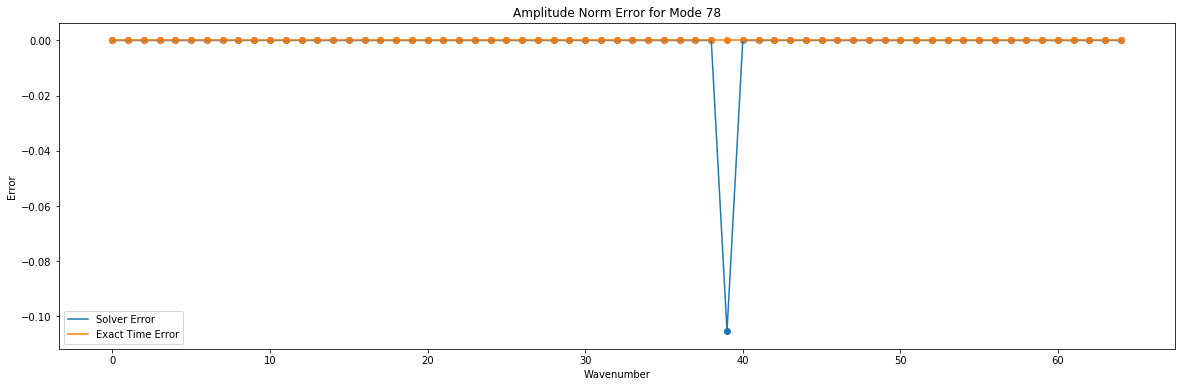


78
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.05272051e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000

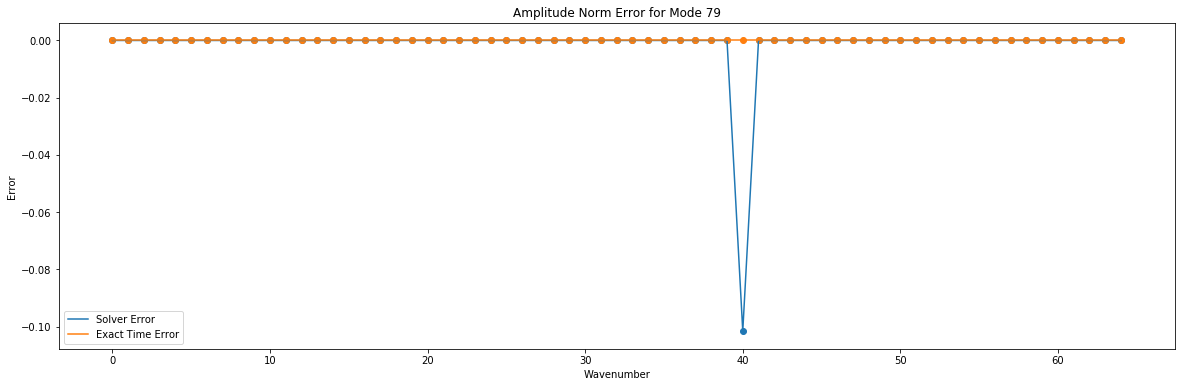


79
solvError:
[-5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.01539081e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -2.00000017e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

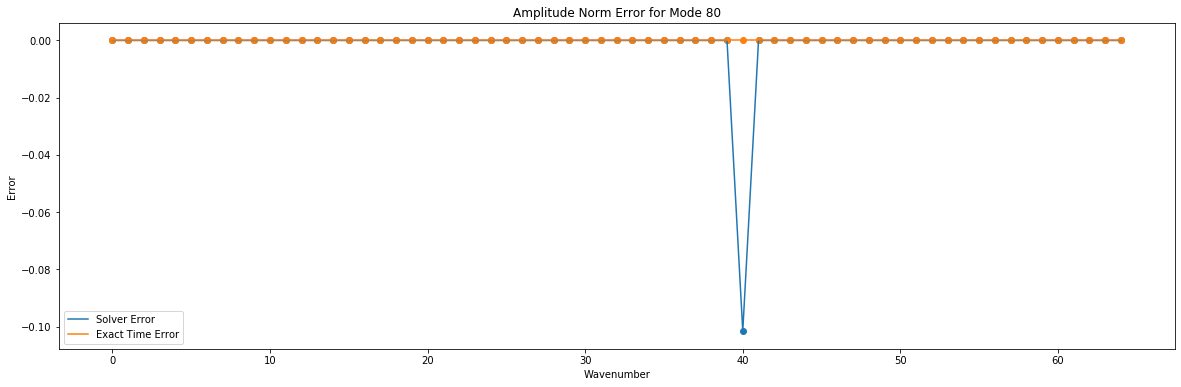


80
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -1.01539081e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000

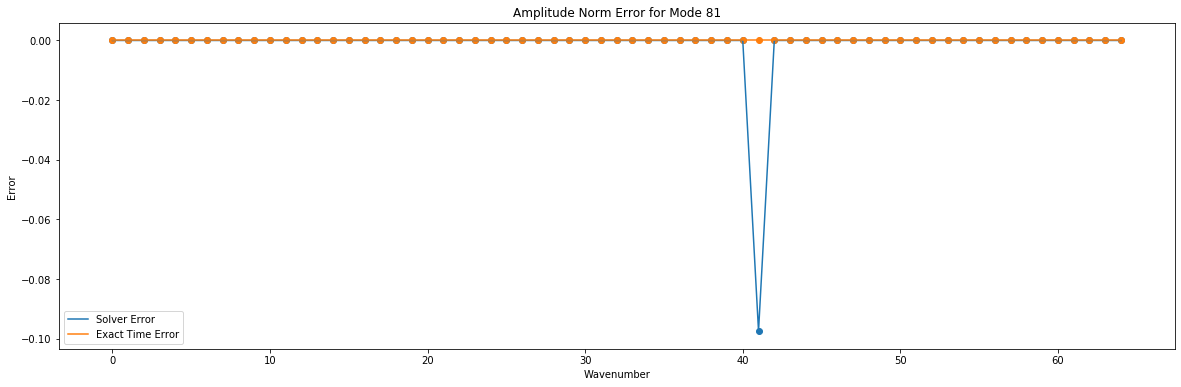


81
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -9.74056499e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

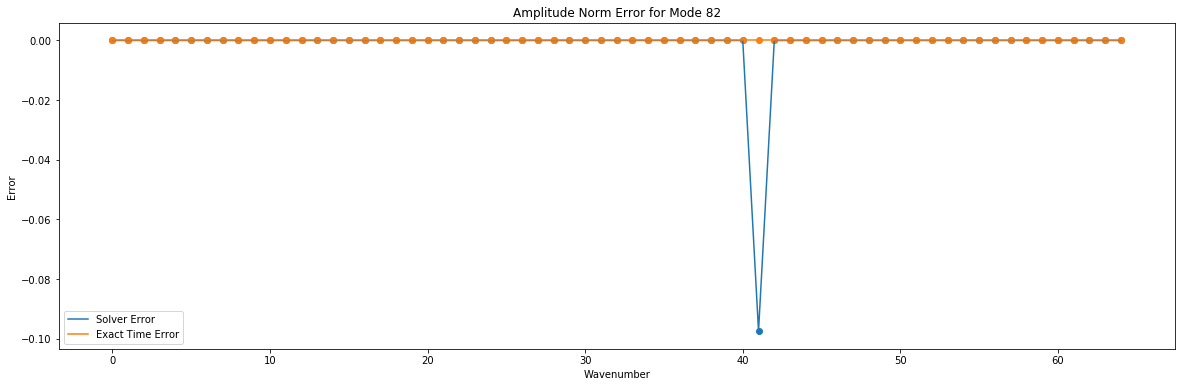


82
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -9.74056499e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

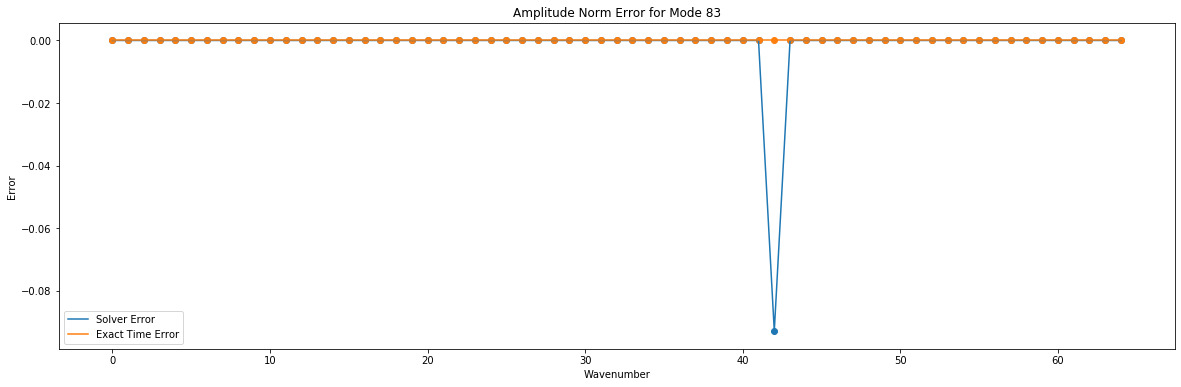


83
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -2.00000017e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -9.29072601e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

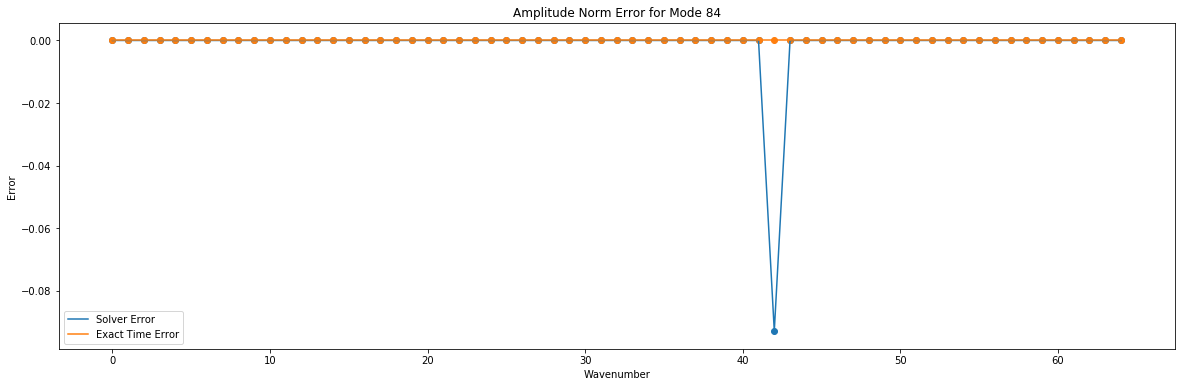


84
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -2.00000017e-10 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -9.29072601e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

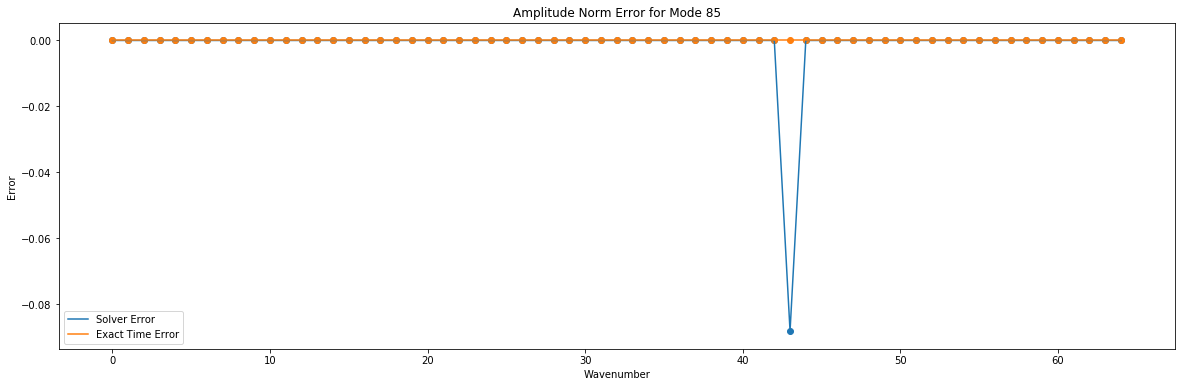


85
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -8.80829895e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000

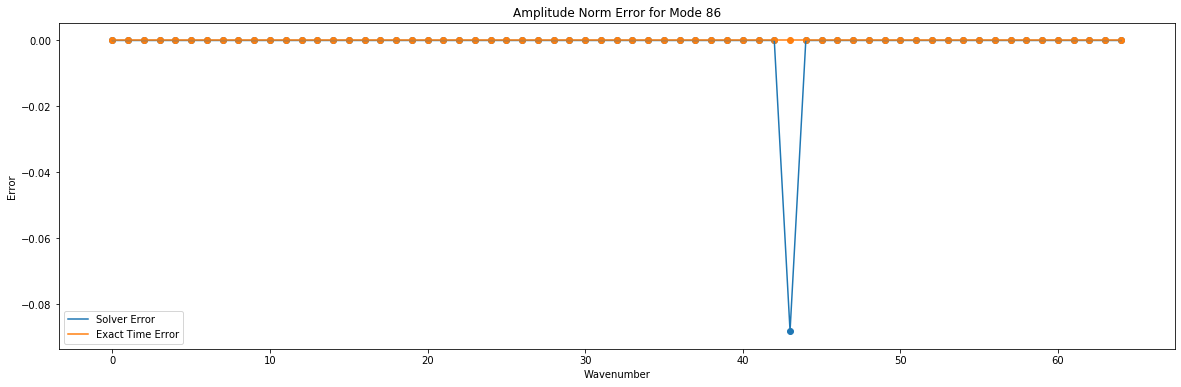


86
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -8.80829895e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000

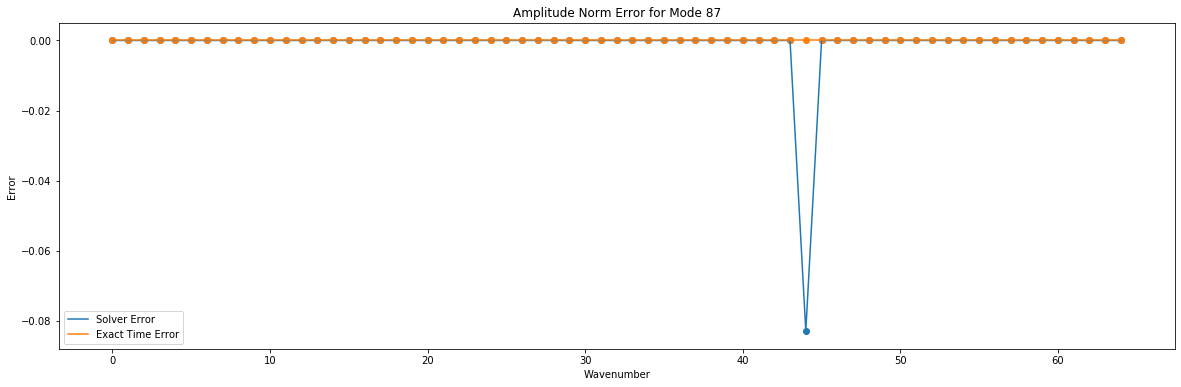


87
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.29752671e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

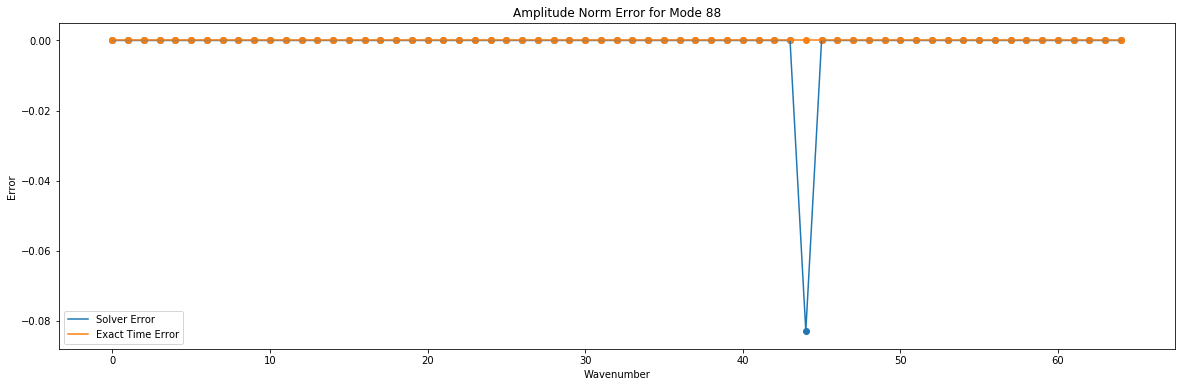


88
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.29752671e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000

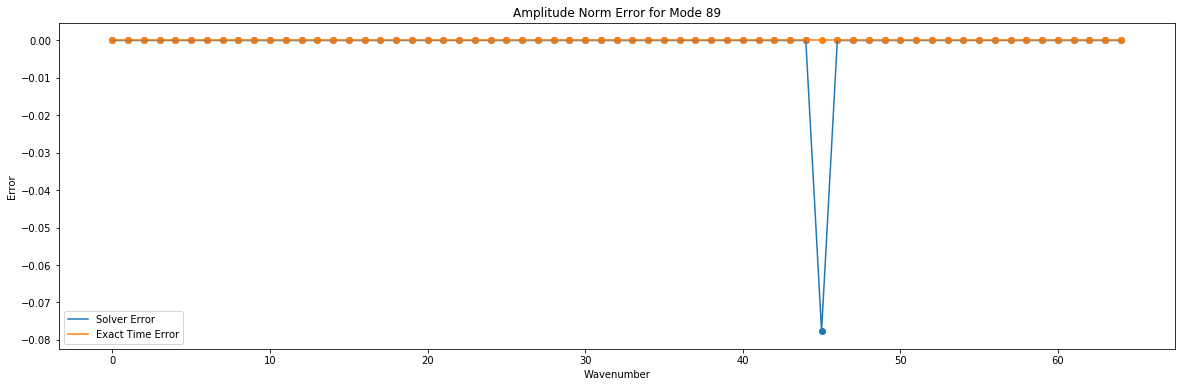


89
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -7.76296139e-02  5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000

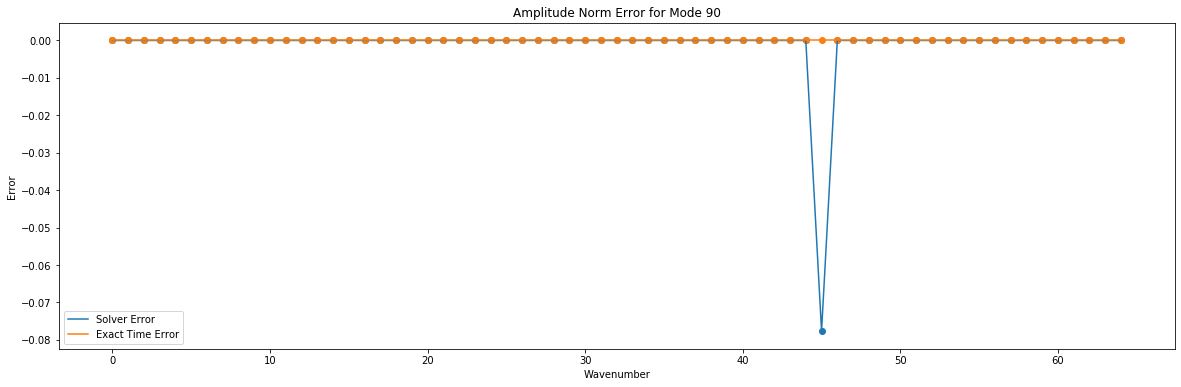


90
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -7.76296139e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000

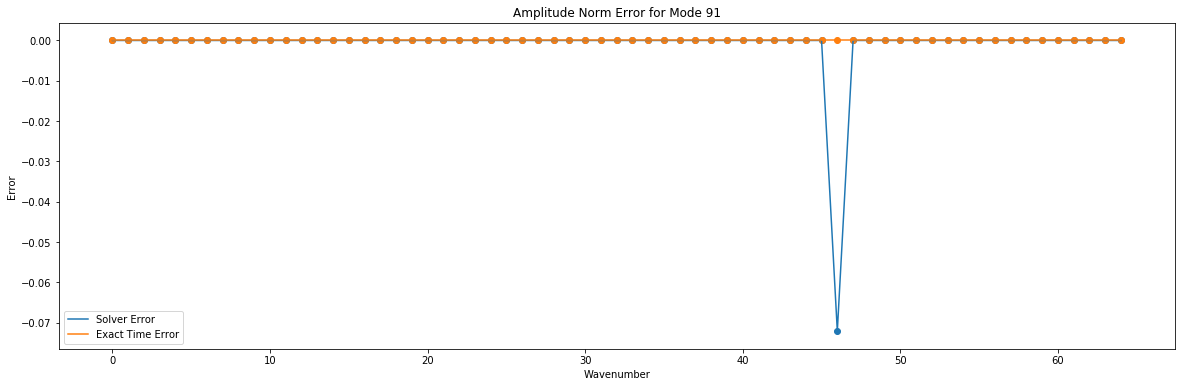


91
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -7.20943476e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000

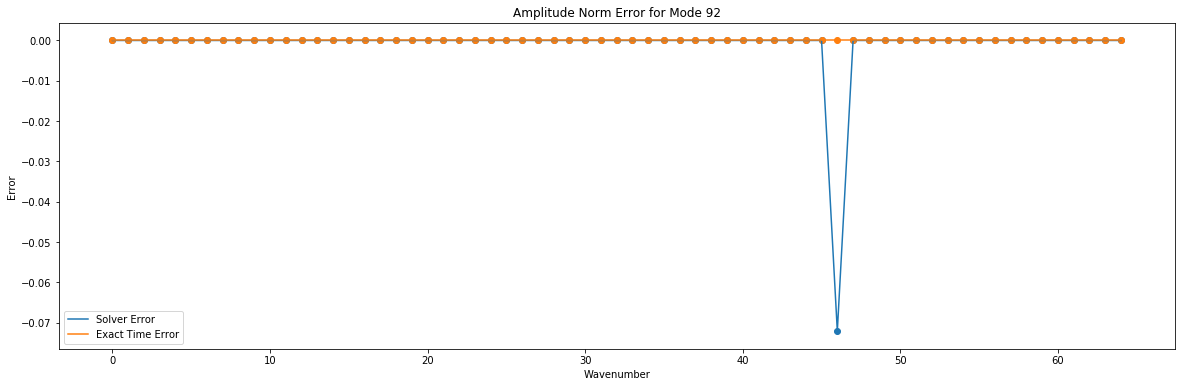


92
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -7.20943476e-02 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000

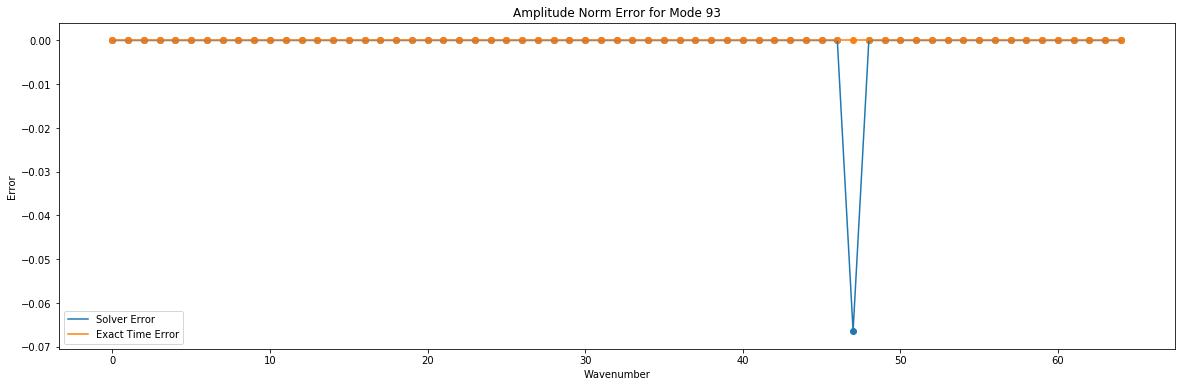


93
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -6.64202467e-02 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

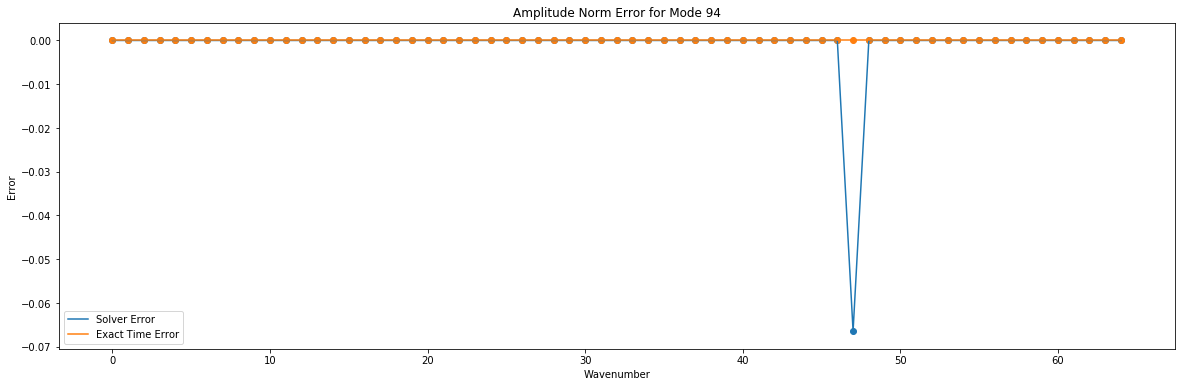


94
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -6.64202467e-02 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000

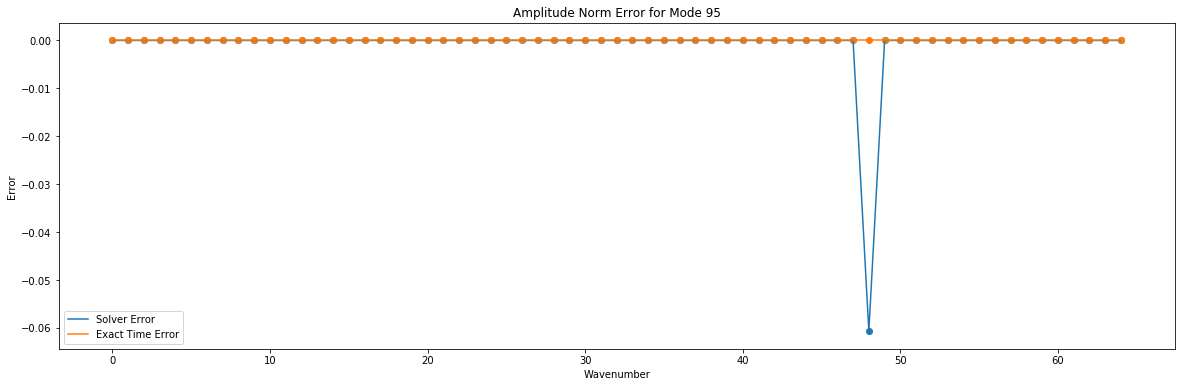


95
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -6.06601718e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

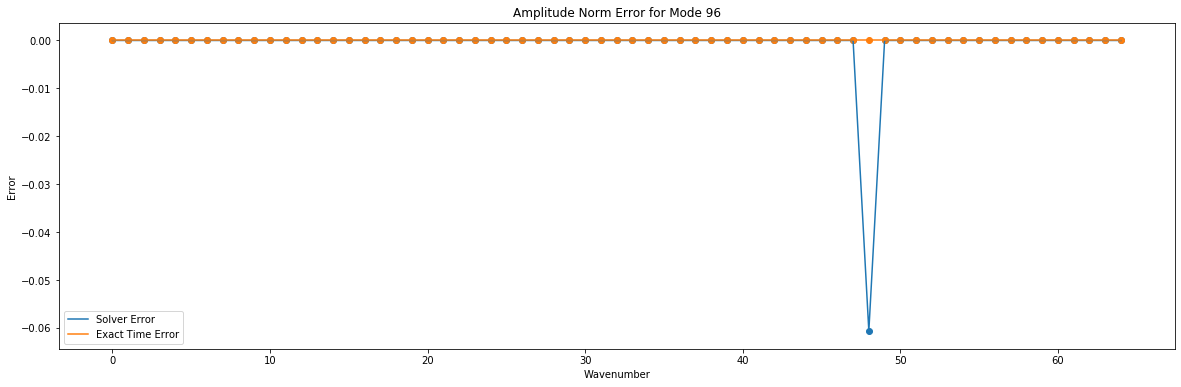


96
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00 -6.06601718e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

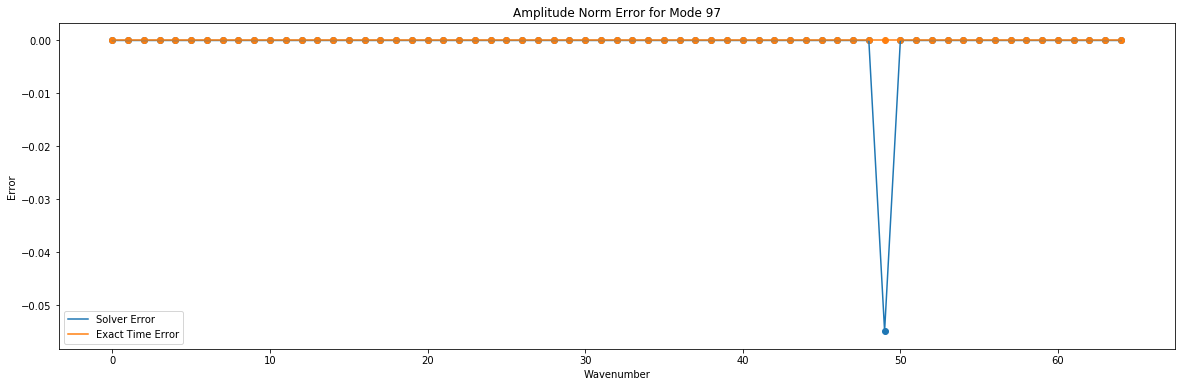


97
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.48686446e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000

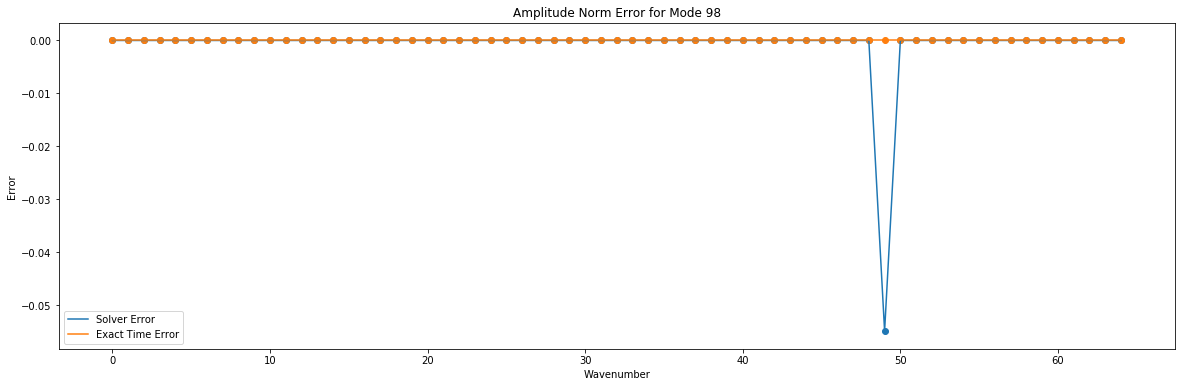


98
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.48686446e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000

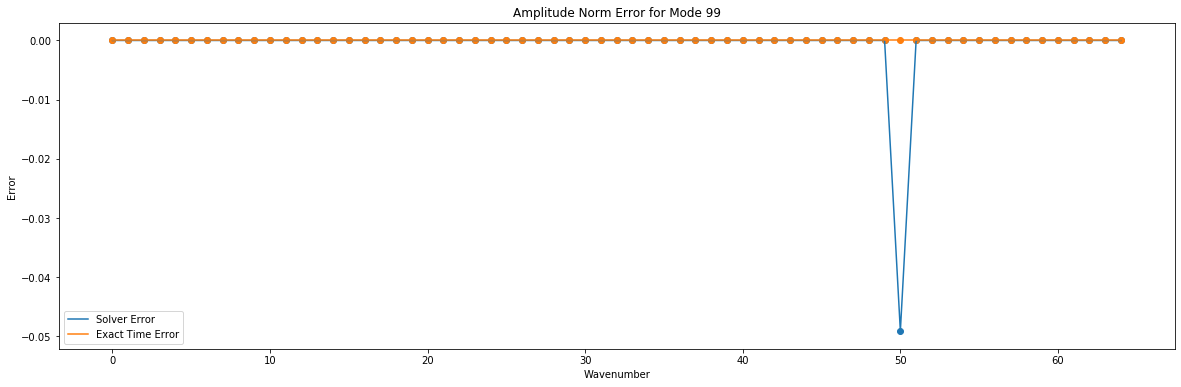


99
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.91013820e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000

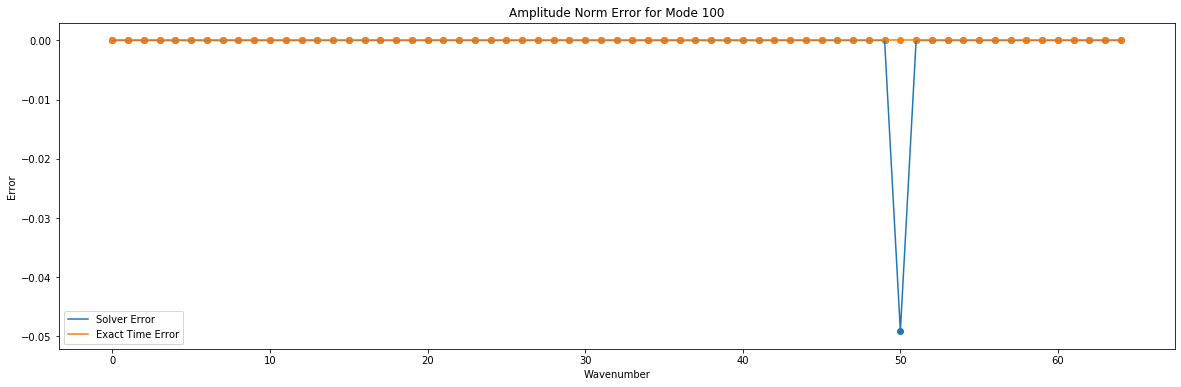


100
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -4.91013820e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.0000

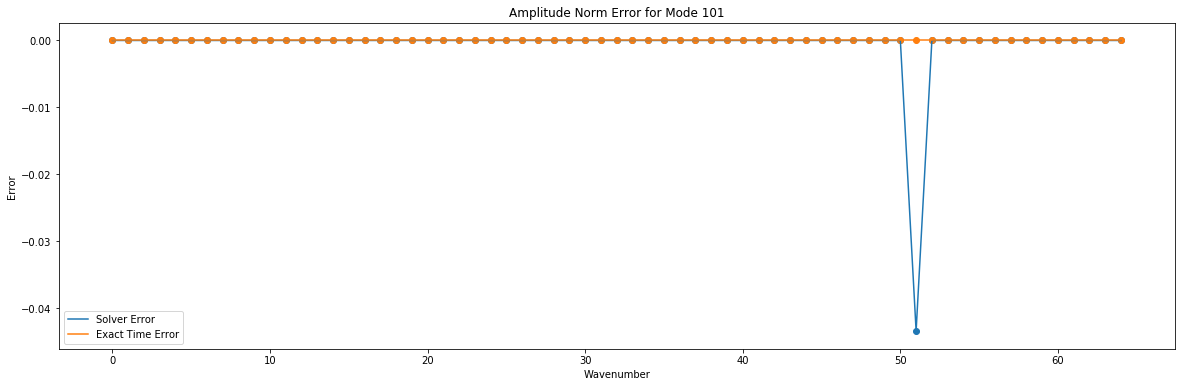


101
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.34147859e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -1.0000

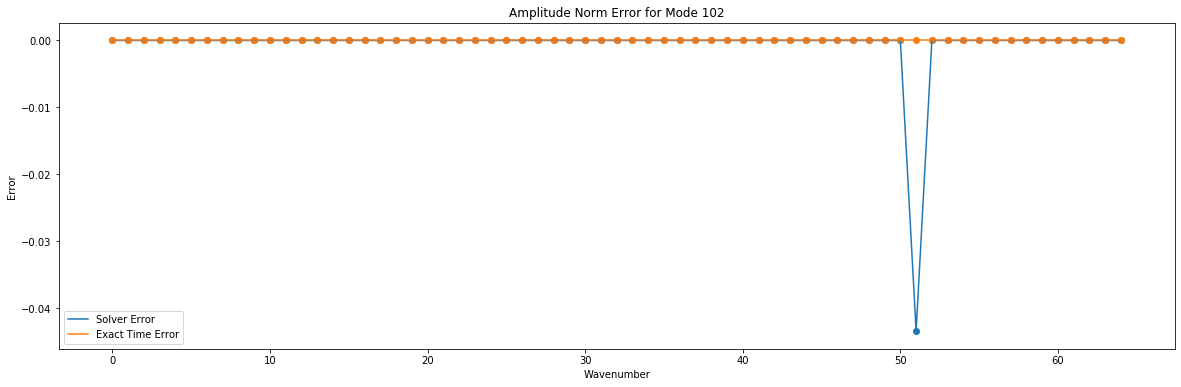


102
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.34147859e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.0000

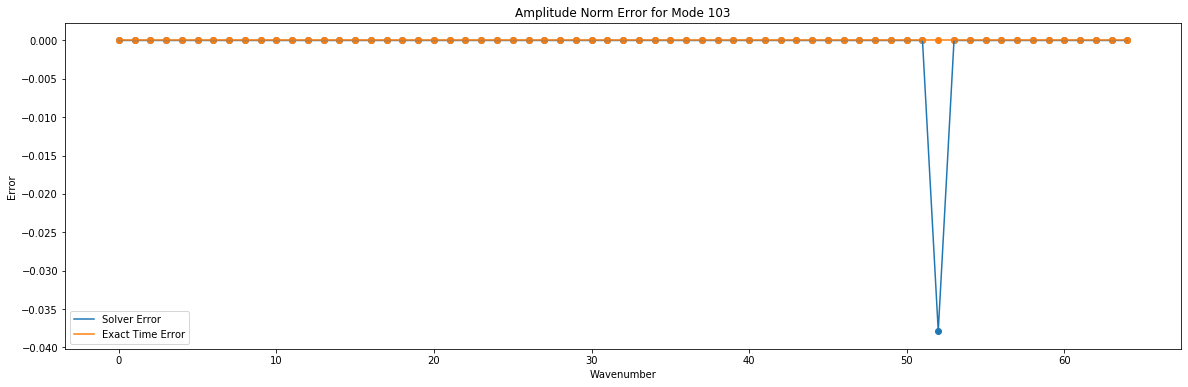


103
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.00000041e-11 -3.78653915e-02 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.0000

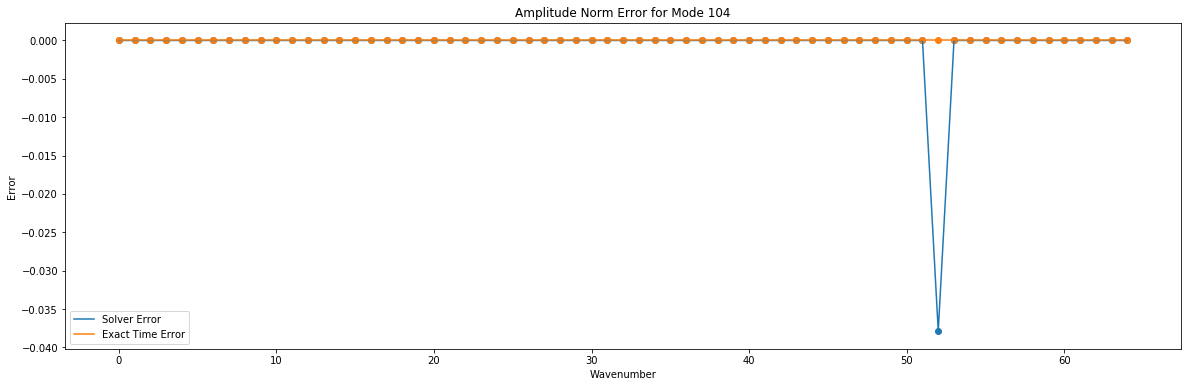


104
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -1.00000008e-10 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.78653915e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.0000

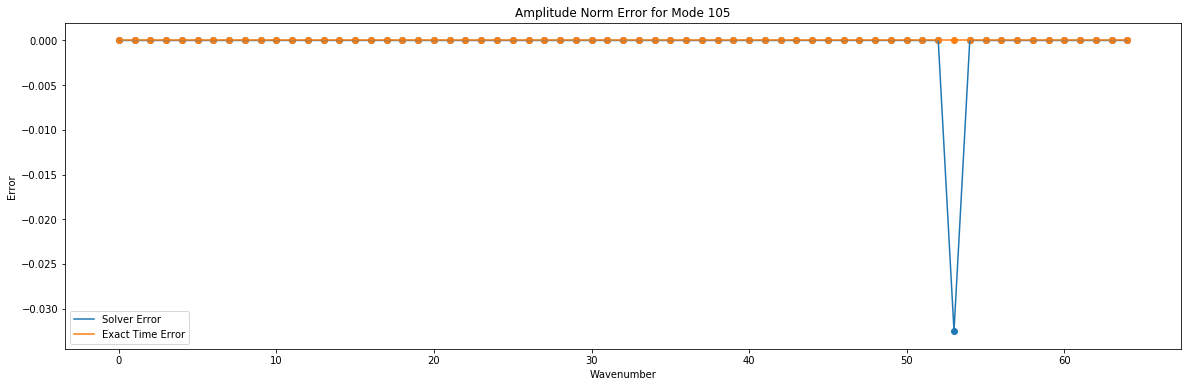


105
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -3.25092774e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

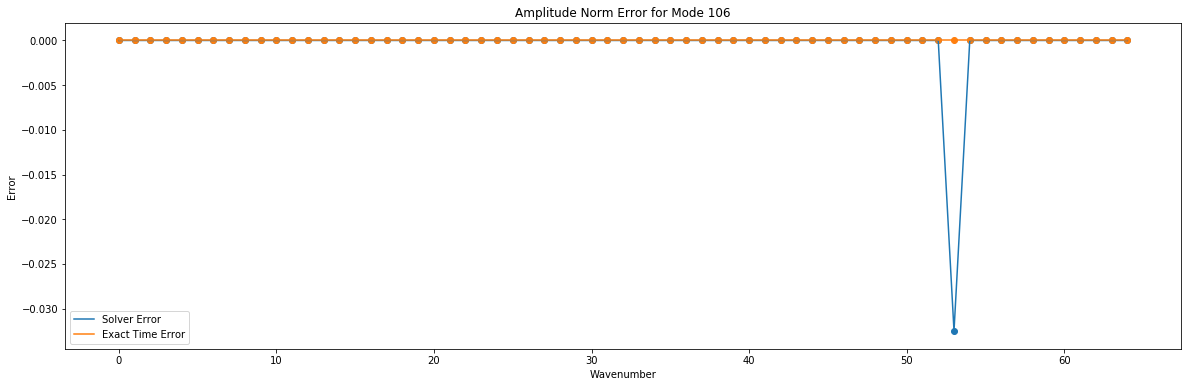


106
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.25092774e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

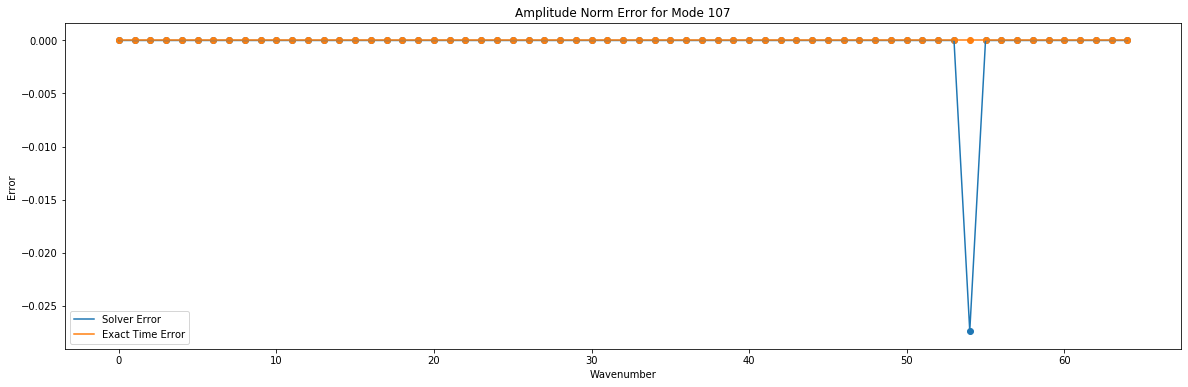


107
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -2.74014410e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.0000

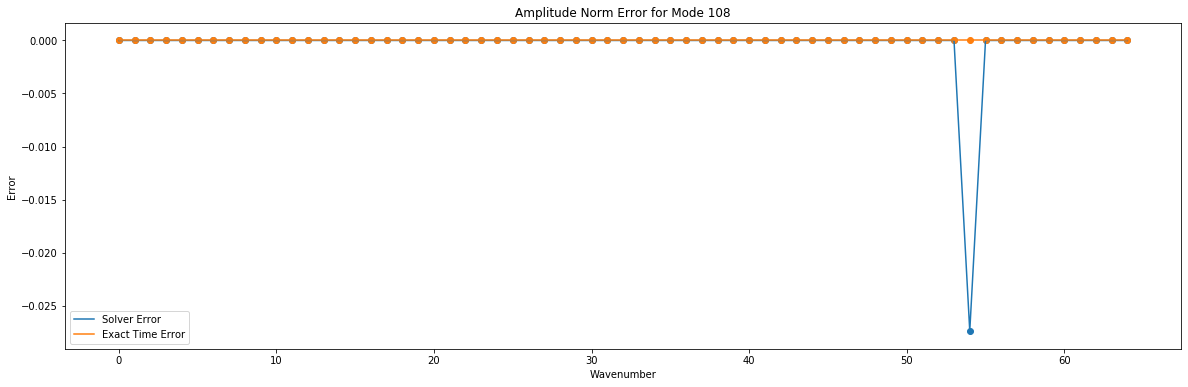


108
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -2.74014410e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.0000

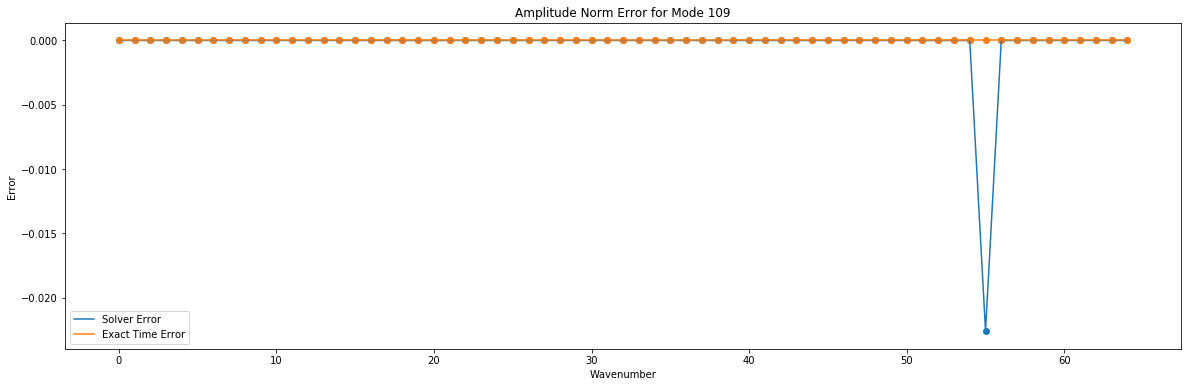


109
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.25951494e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

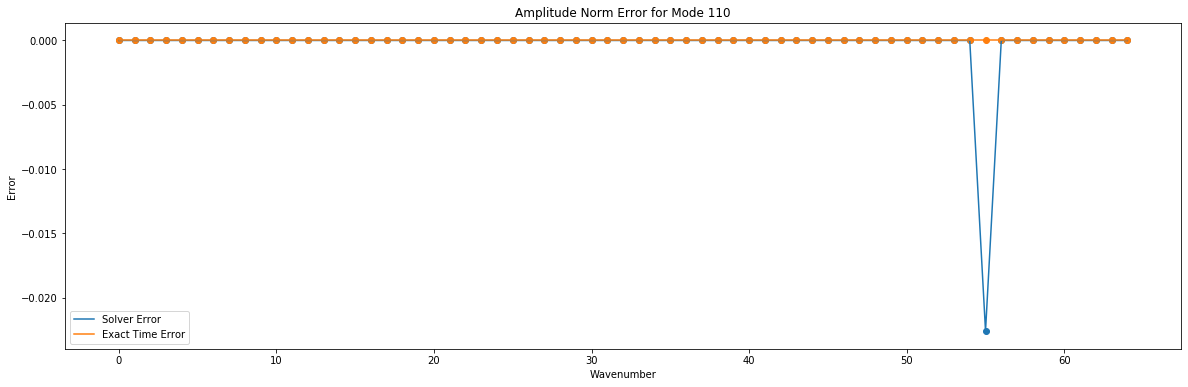


110
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.25951494e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

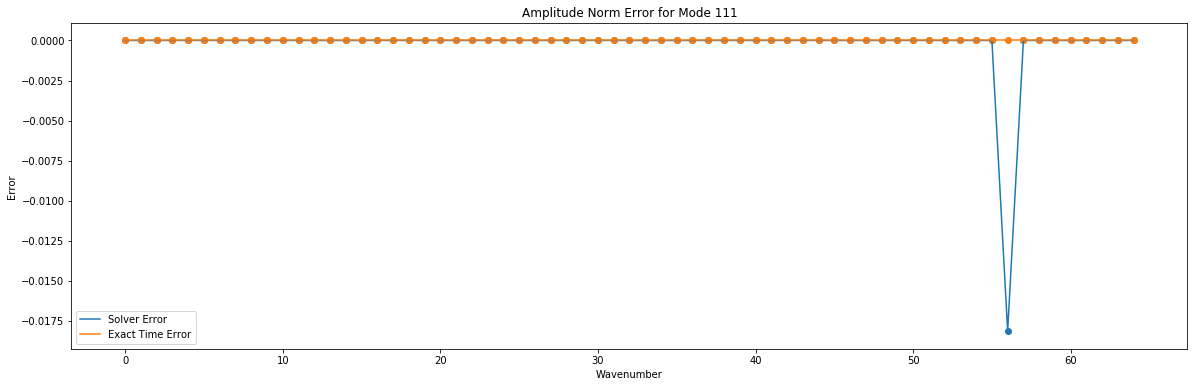


111
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.81412733e-02  5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.0000

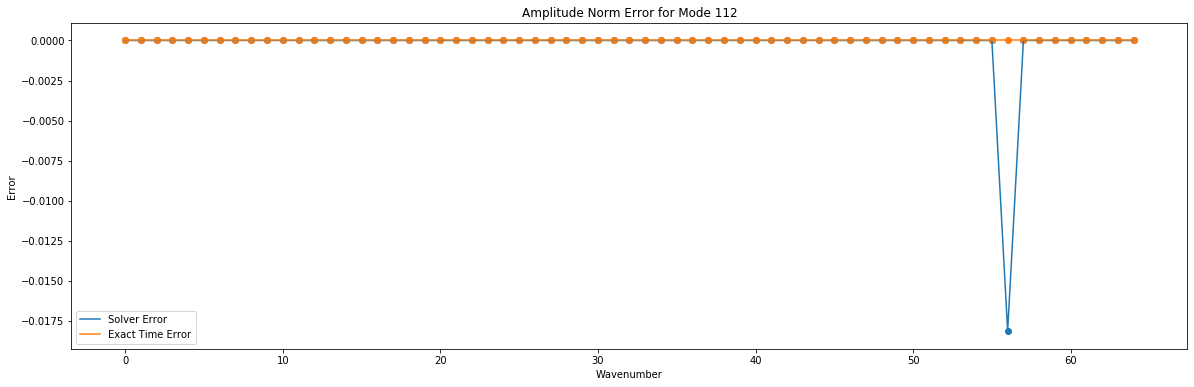


112
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.81412733e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.0000

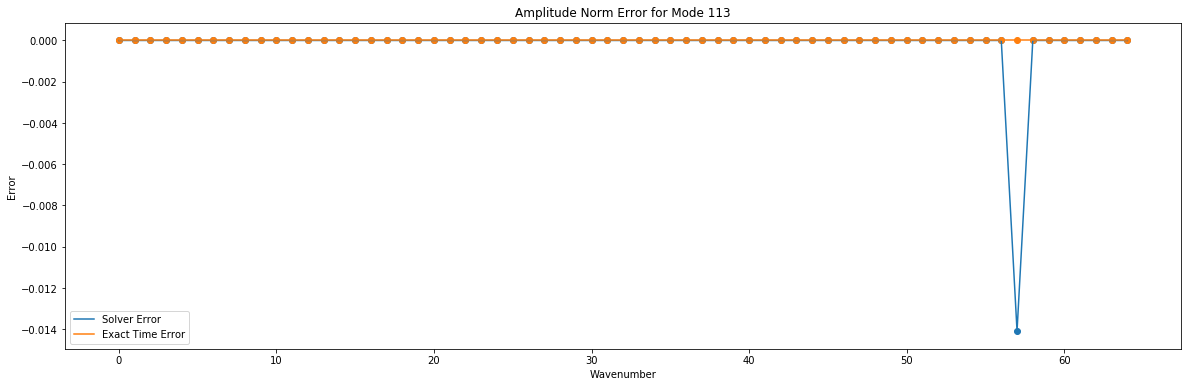


113
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.40876162e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

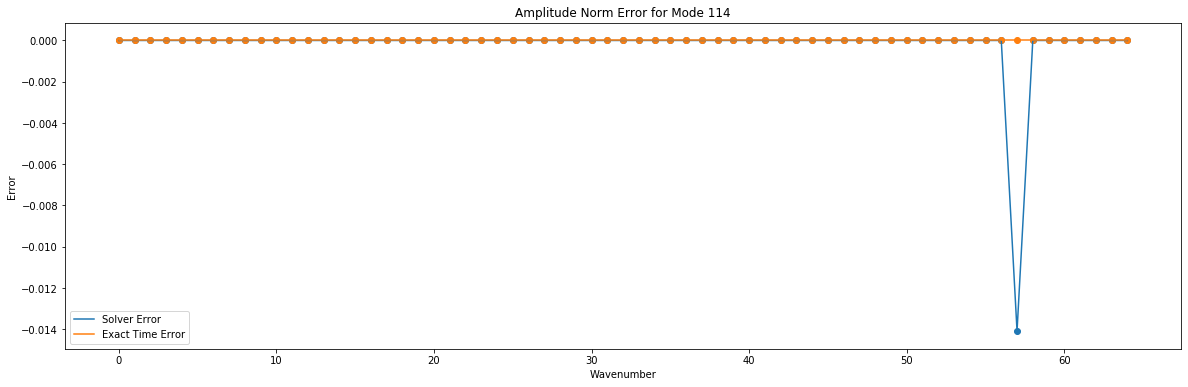


114
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.40876162e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

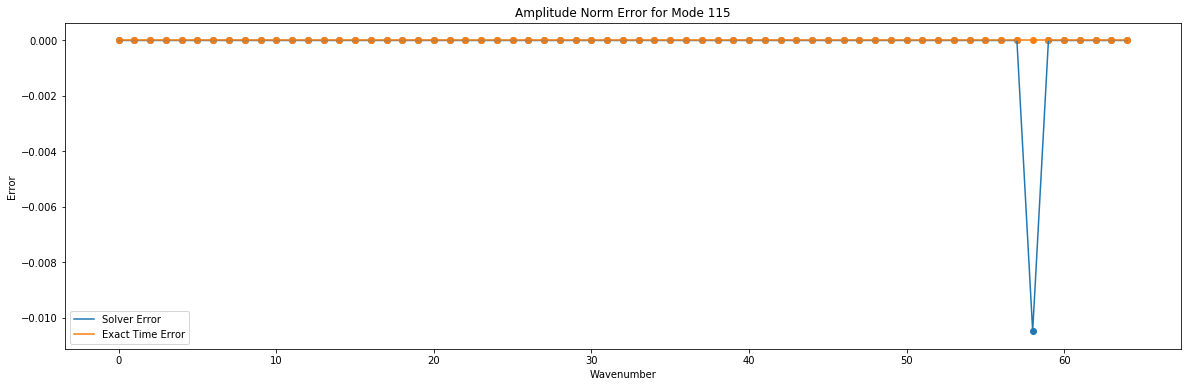


115
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.04782523e-02  0.00000000e+00  0.00000000e+00  0.0000

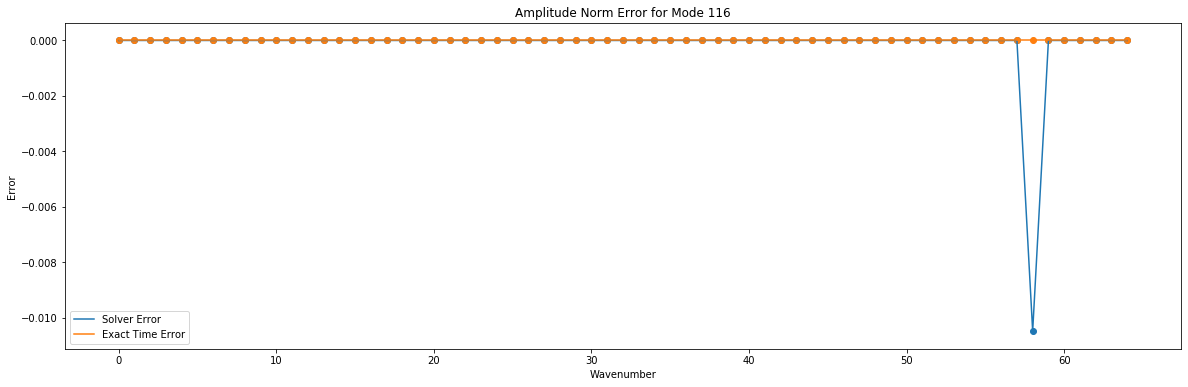


116
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.04782523e-02  0.00000000e+00  0.00000000e+00  0.0000

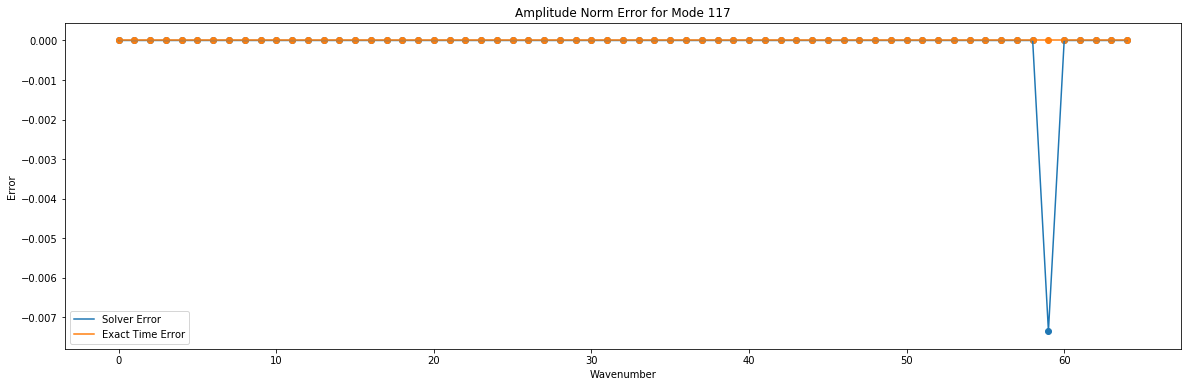


117
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.35288849e-03  0.00000000e+00  0.0000

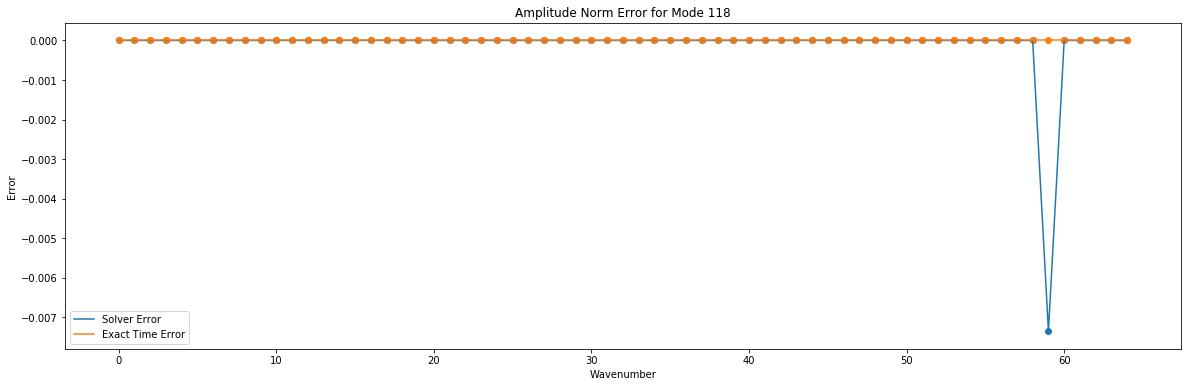


118
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -7.35288849e-03  0.00000000e+00  0.0000

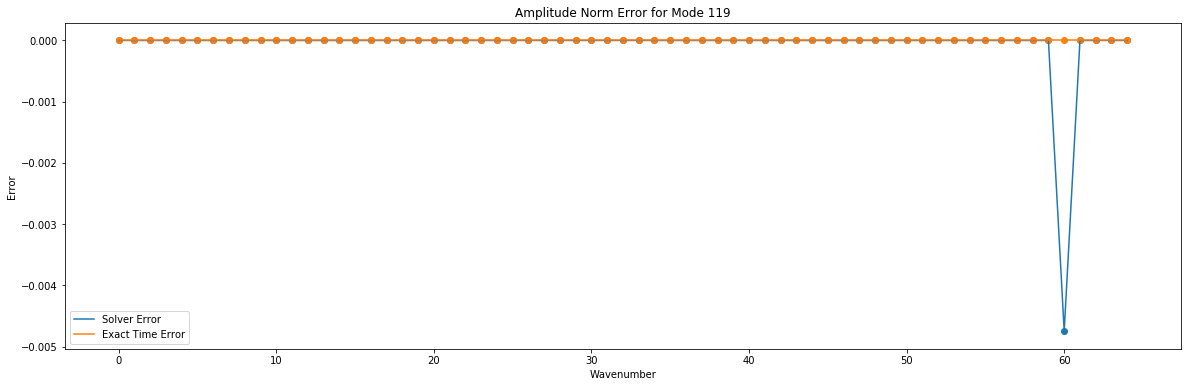


119
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -4.74626570e-03  0.0000

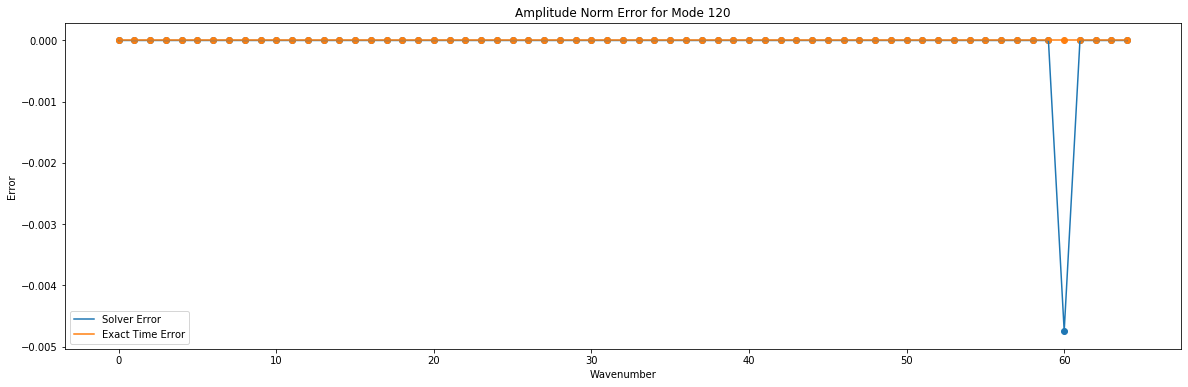


120
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -4.74626570e-03  0.0000

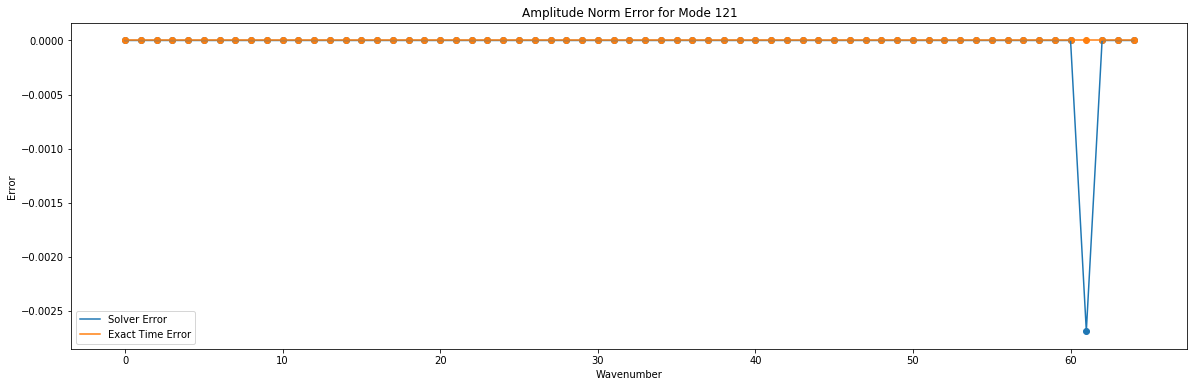


121
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.6876

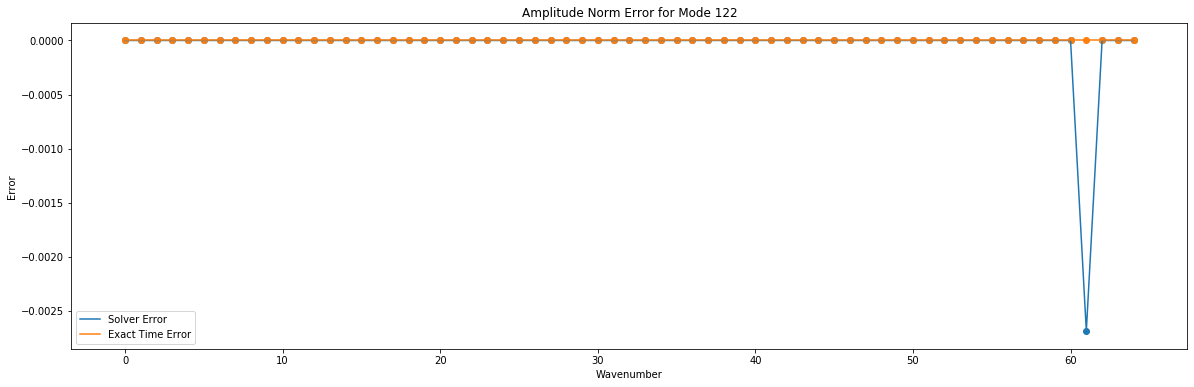


122
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.6876

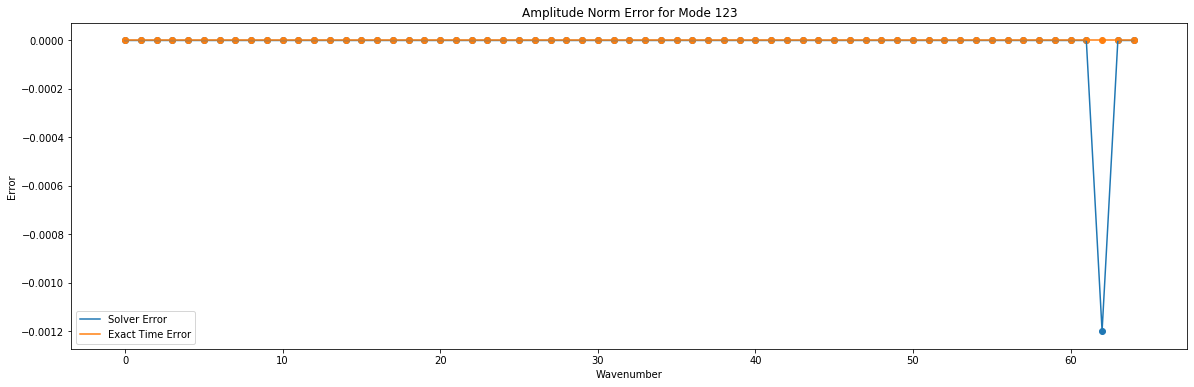


123
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

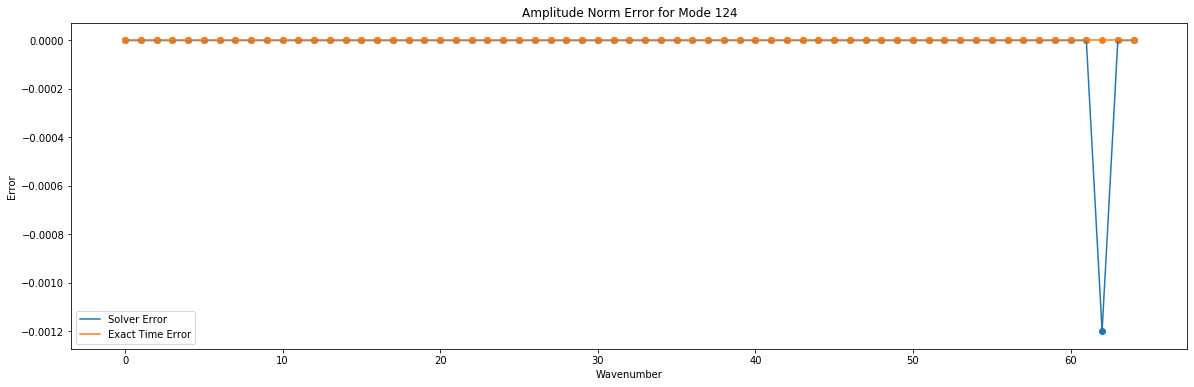


124
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

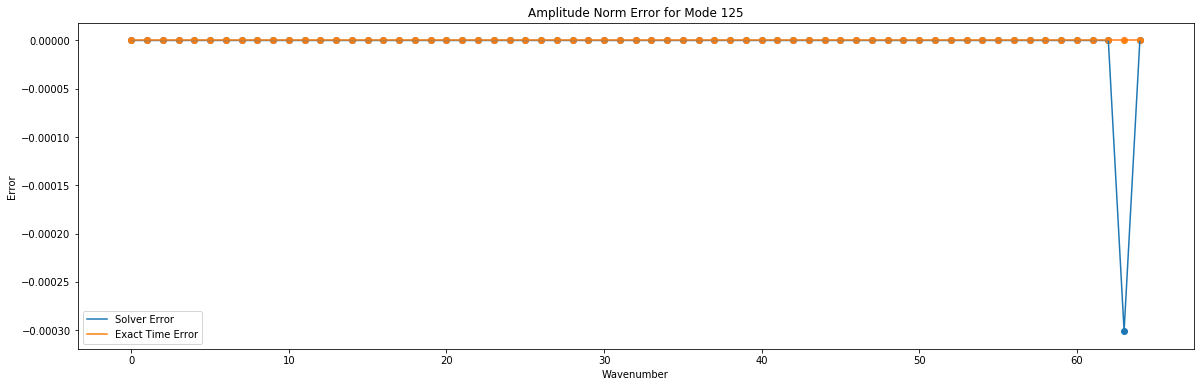


125
solvError:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000008e-10 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

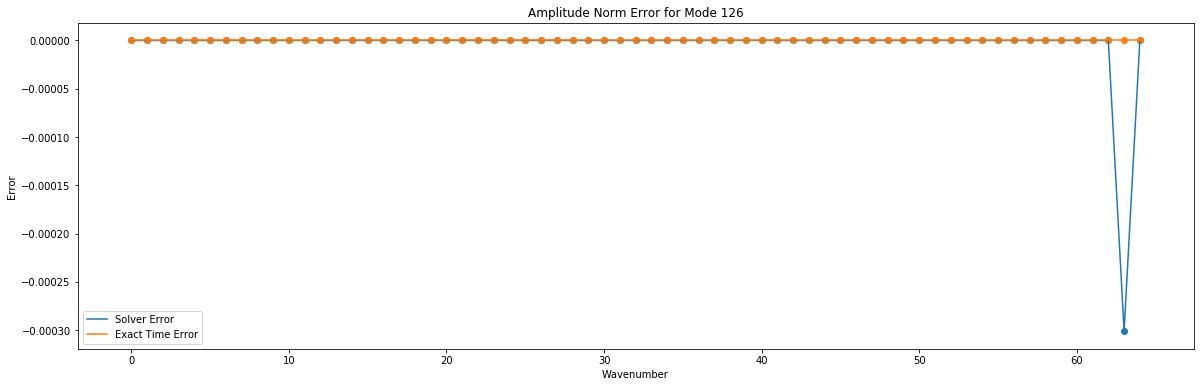


126
solvError:
[ 0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

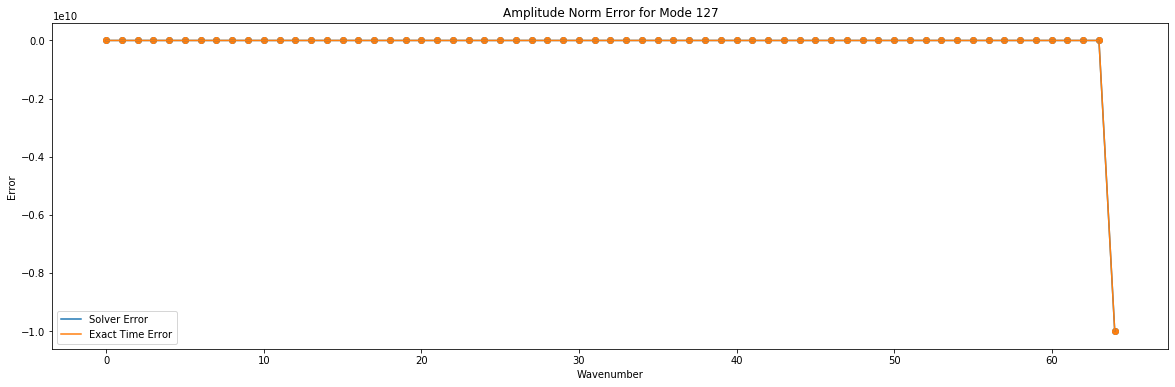


127
solvError:
[ 0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000

In [7]:
ks, solvError, exTimeError, solvNorm = ModeError(omega, nt, c, CFL, deriv, RK, order)


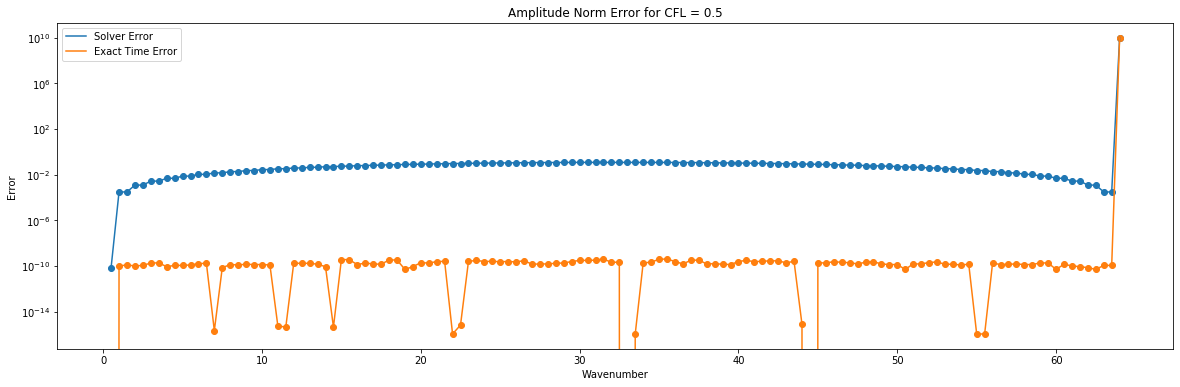

In [8]:
title = 'Amplitude Norm Error for CFL = ' + str(CFL)
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvError, label = 'Solver Error', color = PT.ColorDefault(0))
plt.scatter(ks, solvError, color = PT.ColorDefault(0))
plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
#plt.ylim(-1, 1.1)
plt.yscale('log')
plt.show()

In [9]:
def SolverAmpTheoretical(omega, RK, deriv, CFL):
    nh_max = omega.nh_max
    ks = np.arange((nh_max / 2) + 1)
    theta = (2 * np.pi * ks) / nh_max
    if (deriv == 'U'):
        print('Upwind', RK)
        x = CFL * (1 - np.exp(-1j * theta))
    else:
        x = 0.5 * CFL * (np.exp(1j * theta) - np.exp(-1j * theta))
    coefs = np.arange(RK + 1)[::-1]
    coefs = sp.special.factorial(coefs)**-1
    coefs[1::2] = -coefs[1::2]
    print(coefs)
    p = np.poly1d(coefs)
    print(p)
    amps = p(x)
    return ks, amps

In [10]:
ksT, amps = SolverAmpTheoretical(omega, RK, deriv, CFL)


[ 1. -1.]
 
1 x - 1


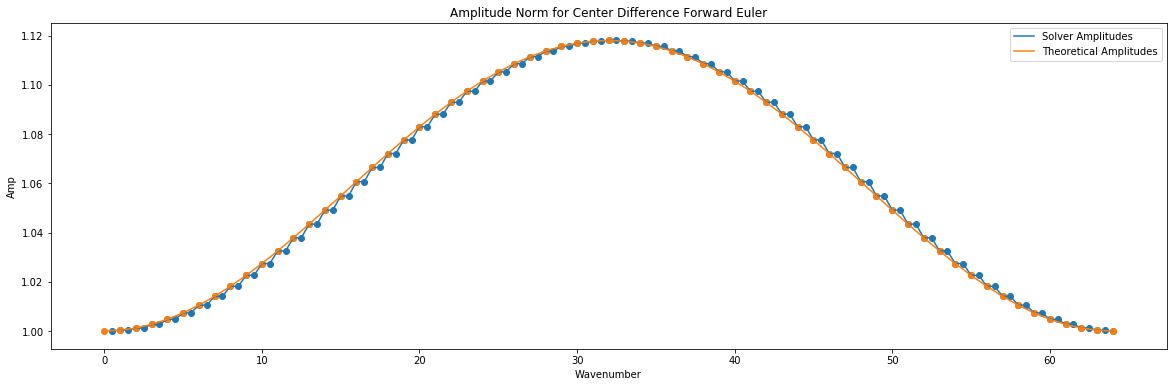

In [11]:
numPoints, font, X, savePath = PT.UsefulPlotVals()
title1 = 'Amplitude Norm for '
if (deriv == 'U'):
    title2 = 'Upwind '
    saveName1 = 'UW'
else:
    title2 = 'Center Difference '
    saveName1 = 'CD'
if (RK == 1):
    title3 = 'Forward Euler'
else:
    if (RK == 2):
        title3 = 'Midpoint Method'
    else:
        title3 = 'Fourth-Order Runge-Kutta'
saveName = savePath + saveName1 + 'RK' + str(RK) + '.png'
title = title1 + title2 + title3
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvNorm, label = 'Solver Amplitudes', color = PT.ColorDefault(0))
plt.scatter(ks, solvNorm, color = PT.ColorDefault(0))
plt.plot(ksT, abs(amps), label = 'Theoretical Amplitudes', color = PT.ColorDefault(1))
plt.scatter(ksT, abs(amps), color = PT.ColorDefault(1))
# plt.plot(ksT, np.imag(amps), label = 'Imaginary Amplitudes', color = PT.ColorDefault(2))
# plt.scatter(ksT, np.imag(amps), color = PT.ColorDefault(2))
# plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
# plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Amp')
plt.legend()
fig.savefig(saveName, bbox_inches = 'tight', dpi = 300, transparent = True)
# plt.ylim(-10, 1000)
# plt.yscale('log')
plt.show()

In [12]:
solvTrunc = np.append(solvNorm[0], solvNorm[1::2])
norm = VectorNorm(solvTrunc - abs(amps), normType = 'L2')
print('Error Norm: ', str(norm))

[ 4.44089210e-16 -2.22044605e-16 -2.22044605e-16 -4.44089210e-16  0.00000000e+00  0.00000000e+00  2.22044605e-16 -4.44089210e-16 -2.22044605e-16  0.00000000e+00  0.00000000e+00 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16  0.00000000e+00  2.22044605e-16  4.44089210e-16  4.44089210e-16 -2.22044605e-16 -2.22044605e-16  0.00000000e+00  2.22044605e-16  2.22044605e-16 -6.66133815e-16 -8.88178420e-16 -2.22044605e-16  4.44089210e-16 -2.22044605e-16  0.00000000e+00 -2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.44089210e-16  6.66133815e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.22044605e-16  2.22044605e-16 -2.22044605e-16  8.88178420e-16  2.22044605e-16 -2.22044605e-16 -2.22044605e-16 -2.22044605e-16  0.00000000e+00  0.00000000e+00 -2.22044605e-16  0.00000000e+00 -2.22044605e-16  0.00000000e+00  2.22044605e-16 -2.22044605e-16  0.00000000e+00 -4.44089210e-16  0.0000

In [13]:
A = arange(8)
print(A)
print(A ** 2)

[0 1 2 3 4 5 6 7]
[ 0  1  4  9 16 25 36 49]


In [14]:
propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, nt, c, CFL, deriv, RK, order)
print(np.round(solvFCoefs, 15))

[[ 1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.000